# **FutureCart: AI-Driven Demand Prediction for Smarter Retail.**


In [428]:
#importing library files
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.cluster import KMeans
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error
import optuna
import warnings
import statsmodels.api as sm
import math
from sklearn.model_selection import train_test_split


- *Adding datasets and merging* 

In [429]:
#datasets
quantity = pd.read_excel('ProductA.xlsx')
clicks = pd.read_excel('ProductA_google_clicks.xlsx')
impression = pd.read_excel('ProductA_fb_impressions.xlsx')

In [430]:
#merging
merged = pd.read_excel('ProductA_google_clicks.xlsx').merge(pd.read_excel('ProductA_fb_impressions.xlsx'),on="Day Index").merge(pd.read_excel('ProductA.xlsx'),on="Day Index")

- *Basic data checks*

In [431]:
merged.head()

Day Index  Clicks  Impressions  Quantity
0 2021-12-01     445          620        14
1 2021-12-02     433          890        10
2 2021-12-03     424          851        13
3 2021-12-04     427          881        22
4 2021-12-05     451          678        33

In [432]:
merged.tail()

Day Index  Clicks  Impressions  Quantity
207 2022-06-26     114         1218        13
208 2022-06-27     106         1311        16
209 2022-06-28     109          885        13
210 2022-06-29      60         1000        16
211 2022-06-30      65          875         8

In [433]:
merged.shape

(212, 4)

In [434]:
#summary
merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 212 entries, 0 to 211
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Day Index    212 non-null    datetime64[ns]
 1   Clicks       212 non-null    int64         
 2   Impressions  212 non-null    int64         
 3   Quantity     212 non-null    int64         
dtypes: datetime64[ns](1), int64(3)
memory usage: 6.8 KB


In [435]:
#describing 
merged.describe()

Day Index     Clicks  Impressions    Quantity
count                  212  212.00000   212.000000  212.000000
mean   2022-03-16 12:00:00  358.20283  1531.702830   17.542453
min    2021-12-01 00:00:00   60.00000   620.000000    5.000000
25%    2022-01-22 18:00:00  154.00000  1209.750000   13.750000
50%    2022-03-16 12:00:00  402.50000  1460.000000   17.000000
75%    2022-05-08 06:00:00  492.75000  1862.000000   21.000000
max    2022-06-30 00:00:00  726.00000  2707.000000   38.000000
std                    NaN  164.52160   440.660783    5.790423

In [436]:
merged.isnull().sum()

Day Index      0
Clicks         0
Impressions    0
Quantity       0
dtype: int64

**To check if there any outlier present**

In [437]:
merged.boxplot()

<Axes: >

- *Box plot for clicks,impression,quantity*

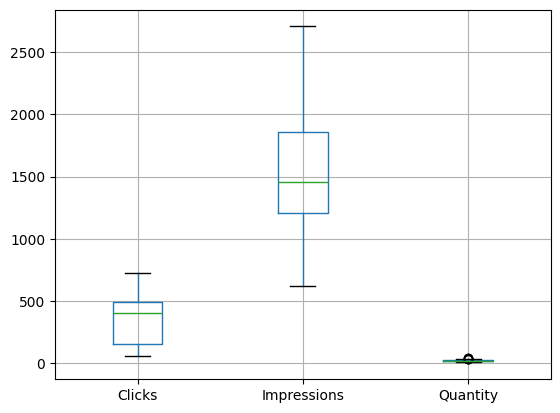

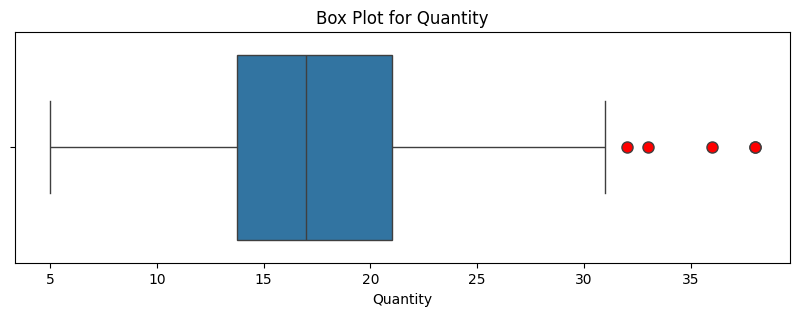

In [438]:
plt.figure(figsize=(10, 3))
sns.boxplot(x=merged['Quantity'], flierprops=dict(marker='o', markerfacecolor="red", markersize=8))
plt.xlabel("Quantity")
plt.title("Box Plot for Quantity")
plt.show()

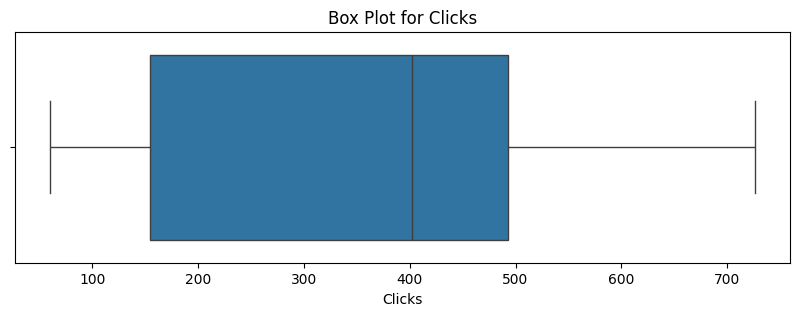

In [439]:
plt.figure(figsize=(10, 3))
sns.boxplot(x=merged['Clicks'], flierprops=dict(marker='o', markerfacecolor="red", markersize=8))
plt.xlabel("Clicks")
plt.title("Box Plot for Clicks")
plt.show()

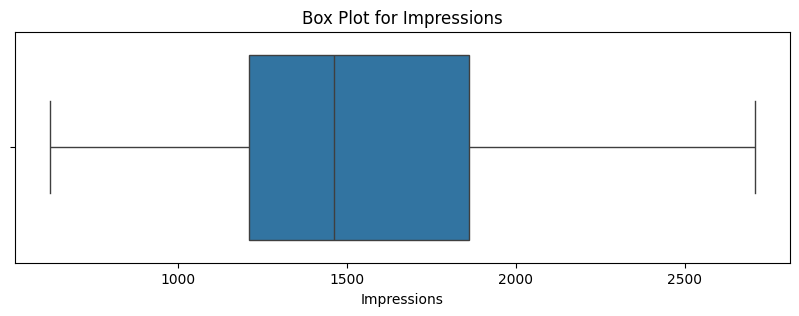

In [440]:
plt.figure(figsize=(10, 3))
sns.boxplot(x=merged['Impressions'], flierprops=dict(marker='o', markerfacecolor="red", markersize=8))
plt.xlabel("Impressions")
plt.title("Box Plot for Impressions")
plt.show()

- *Checking outlier in each column*

In [441]:
def outlier_finding(merged):
    q1 , q3 = merged.quantile(0.25), merged.quantile(0.75)
    IQR = q3 - q1
    outliers = merged[(merged < (q1 - 1.5 *IQR))| (merged > (q3 + 1.5 * IQR))]
    return outliers
outlier_quantity = len(outlier_finding(merged['Quantity']))
outlier_clicks = len(outlier_finding(merged['Clicks']))
outlier_impressions = len(outlier_finding(merged['Impressions']))
#printing outliers
print("Outliers in Quantity:",outlier_quantity)
print("Outliers in Clicks:",outlier_clicks)
print("Outlier in Impressions:",outlier_impressions)

Outliers in Quantity: 5
Outliers in Clicks: 0
Outlier in Impressions: 0


- *So there are 5 outliers in quantity*

In [442]:
print("Quantity: \n",outlier_finding(merged['Quantity']))

Quantity: 
 4      33
9      38
78     38
113    32
142    36
Name: Quantity, dtype: int64


- *Replacing the outlier with 96th percentile*

In [443]:
percentile = merged["Quantity"].quantile(0.96)
print(percentile)

28.560000000000002


In [444]:
def outlier_percentile(series):
    q1, q3 = series.quantile([0.25,0.75])
    IQR = q3 - q1
    #calculating upper and lower bound
    lower = q1 - 1.5*IQR
    upper = q3 + 1.5*IQR
    percentile_96 = series.quantile(0.96)
    return series.apply(lambda x: percentile_96 if(x < lower or x > upper)else x)
    

In [445]:
merged['imputed_quantity'] = outlier_percentile(merged['Quantity'])

In [446]:
#calculating imputed quantity
print("quantity:\t",len(outlier_finding(merged['imputed_quantity'])))

quantity:	 0


**Feature Engineering**

In [447]:
merged.head()

Day Index  Clicks  Impressions  Quantity  imputed_quantity
0 2021-12-01     445          620        14             14.00
1 2021-12-02     433          890        10             10.00
2 2021-12-03     424          851        13             13.00
3 2021-12-04     427          881        22             22.00
4 2021-12-05     451          678        33             28.56

In [448]:
merged['imputed_quantity'] = outlier_percentile(merged['Quantity'])

In [449]:
#transforming data to log 
merged['log_quantity'] = np.log1p(merged['Quantity'])
merged['log_clicks'] = np.log1p(merged['Clicks'])
merged['log_impression'] = np.log1p(merged['Impressions'])

In [450]:
#month year Extracting
merged['ym'] = merged['Day Index'].dt.to_period('M')

In [451]:
#month name
merged['MonthName'] = merged['ym'].dt.strftime('%B')
month_order = ['December','January','February','March','April','May','June']
merged['MonthName'] = pd.Categorical(merged['MonthName'], categories = month_order, ordered = True)

In [452]:
#days of week
merged['daysofweek'] = merged['Day Index'].dt.day_name()
order_week = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
merged['daysofweek'] = pd.Categorical(merged['daysofweek'], categories = order_week, ordered = True)


In [453]:
#week of month
def weekOfMonth(date):
    first_day = date.replace(day=1)
    adjusted_dom = date.day + first_day.weekday()
    return int(np.ceil(adjusted_dom/7.0))

merged['weekOfMonth'] = merged['Day Index'].apply(weekOfMonth)

In [454]:
#extracting to numeric values
def dayToNumber(day):
    day_orders = {'Monday':1,'Tuesday':2,'Wednesday':3,'Thursday':4,'Friday':5,'Saturday':6,'Sunday':7}
    return day_orders.get(day,0)

def monthToNumber(month):
    month_orders = {'January':1,'February':2,'March':3,'April':4,'May':5,'June':6,'July':7,'August':8,'September':9,'October':10,'November':11,'December':12}
    return month_orders.get(month,0)

merged['daysOfWeekNum'] = merged['daysofweek'].apply(dayToNumber)
merged['MonthNum'] = merged['MonthName'].apply(monthToNumber)

In [455]:
#weekdays and months in sepearate columns
merged.loc[merged['daysofweek'] == 'Monday', 'Weekday_Monday'] = 1
merged.loc[merged['daysofweek'] == 'Tuesday', 'Weekday_Tuesday'] = 1
merged.loc[merged['daysofweek'] == 'Wednesday', 'Weekday_Wednesday'] = 1
merged.loc[merged['daysofweek'] == 'Thursday', 'Weekday_Thursday'] = 1
merged.loc[merged['daysofweek'] == 'Friday', 'Weekday_Friday'] = 1
merged.loc[merged['daysofweek'] == 'Saturday', 'Weekday_Saturday'] = 1
merged.loc[merged['daysofweek'] == 'Sunday', 'Weekday_Sunday'] = 1

merged.loc[merged['MonthName'] == 'January', 'Weekday_January'] = 1
merged.loc[merged['MonthName'] == 'February', 'Weekday_February'] = 1
merged.loc[merged['MonthName'] == 'March', 'Weekday_March'] = 1
merged.loc[merged['MonthName'] == 'April', 'Weekday_April'] = 1
merged.loc[merged['MonthName'] == 'May', 'Weekday_May'] = 1
merged.loc[merged['MonthName'] == 'June', 'Weekday_June'] = 1
merged.loc[merged['MonthName'] == 'July', 'Weekday_July'] = 1
merged.loc[merged['MonthName'] == 'August', 'Weekday_August'] = 1
merged.loc[merged['MonthName'] == 'September', 'Weekday_September'] = 1
merged.loc[merged['MonthName'] == 'October', 'Weekday_October'] = 1
merged.loc[merged['MonthName'] == 'November', 'Weekday_November'] = 1
merged.loc[merged['MonthName'] == 'December', 'Weekday_December'] = 1

In [456]:
#Replacing
weekday_columns = ['Weekday_Monday','Weekday_Tuesday','Weekday_Wednesday','Weekday_Thursday','Weekday_Friday','Weekday_Saturday','Weekday_Sunday']
month_columns = ['Weekday_January','Weekday_February','Weekday_March','Weekday_April','Weekday_May', 'Weekday_June', 'Weekday_July','Weekday_August','Weekday_September','Weekday_October','Weekday_November','Weekday_December']
#fill 0 for NAN
merged[weekday_columns] = merged[weekday_columns].fillna(0)
merged[month_columns] = merged[month_columns].fillna(0)

In [457]:
merged.columns

Index(['Day Index', 'Clicks', 'Impressions', 'Quantity', 'imputed_quantity',
       'log_quantity', 'log_clicks', 'log_impression', 'ym', 'MonthName',
       'daysofweek', 'weekOfMonth', 'daysOfWeekNum', 'MonthNum',
       'Weekday_Monday', 'Weekday_Tuesday', 'Weekday_Wednesday',
       'Weekday_Thursday', 'Weekday_Friday', 'Weekday_Saturday',
       'Weekday_Sunday', 'Weekday_January', 'Weekday_February',
       'Weekday_March', 'Weekday_April', 'Weekday_May', 'Weekday_June',
       'Weekday_July', 'Weekday_August', 'Weekday_September',
       'Weekday_October', 'Weekday_November', 'Weekday_December'],
      dtype='object')

In [458]:
merged.head()

Day Index  Clicks  Impressions  Quantity  imputed_quantity  log_quantity  \
0 2021-12-01     445          620        14             14.00      2.708050   
1 2021-12-02     433          890        10             10.00      2.397895   
2 2021-12-03     424          851        13             13.00      2.639057   
3 2021-12-04     427          881        22             22.00      3.135494   
4 2021-12-05     451          678        33             28.56      3.526361   

   log_clicks  log_impression       ym MonthName  ... Weekday_March  \
0    6.100319        6.431331  2021-12  December  ...           0.0   
1    6.073045        6.792344  2021-12  December  ...           0.0   
2    6.052089        6.747587  2021-12  December  ...           0.0   
3    6.059123        6.782192  2021-12  December  ...           0.0   
4    6.113682        6.520621  2021-12  December  ...           0.0   

   Weekday_April Weekday_May Weekday_June  Weekday_July  Weekday_August  \
0            0.0         0.0          0.0           0.0             0.0   
1            0.0         0.0          0.0           0.0             0.0   
2            0.0         0.0          0.0           0.0             0.0   
3            0.0         0.0          0.0           0.0             0.0   
4            0.0         0.0          0.0           0.0             0.0   

   Weekday_September  Weekday_October  Weekday_November  Weekday_December  
0                0.0              0.0               0.0               1.0  
1                0.0              0.0               0.0               1.0  
2                0.0              0.0               0.0               1.0  
3                0.0              0.0               0.0               1.0  
4                0.0              0.0               0.0               1.0  

[5 rows x 33 columns]

### *So this the final data for future analysis*

### **DATA ANALYSIS**

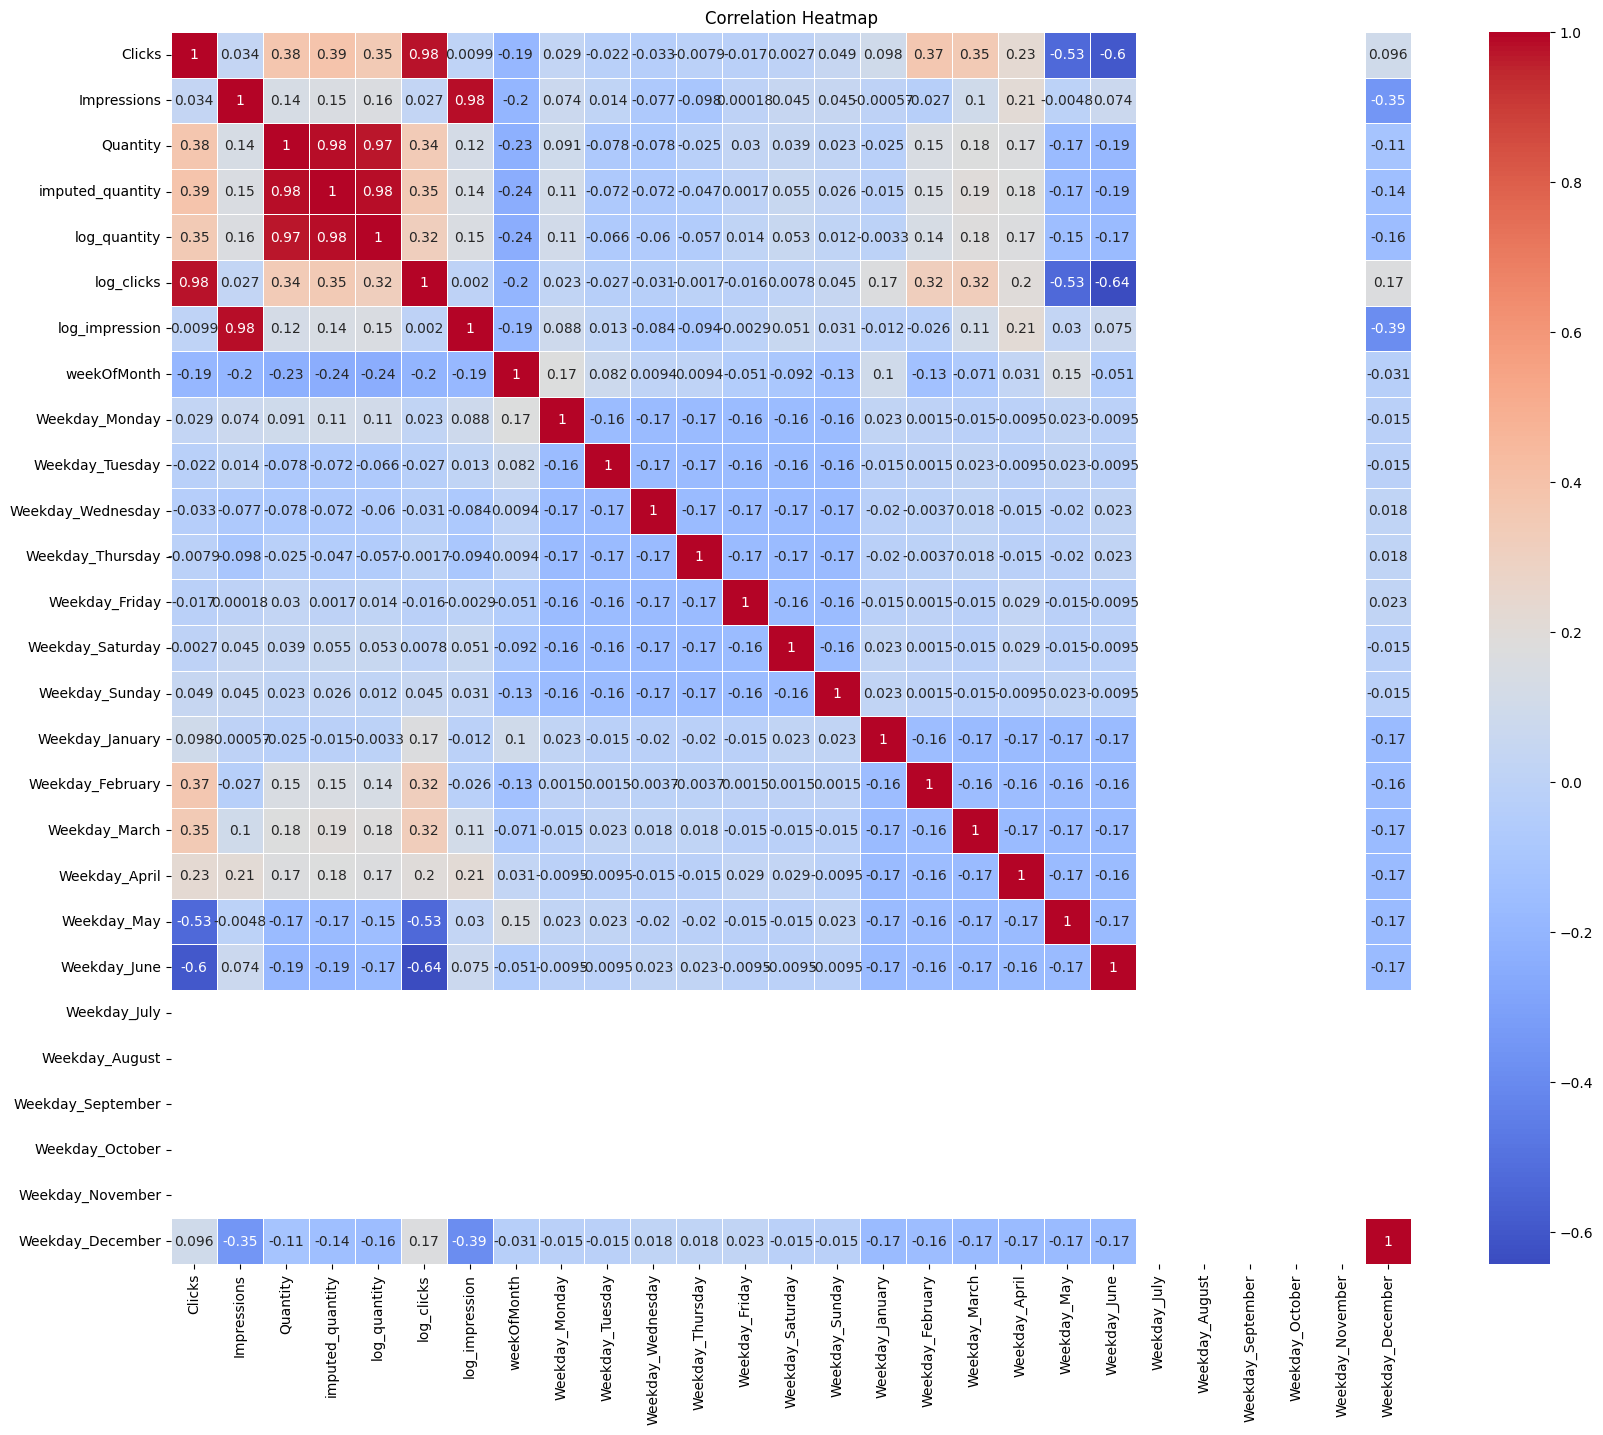

In [459]:
#correlation heatmap
plt.figure(figsize=(20,16))
sns.heatmap(merged.corr(numeric_only=True), annot=True, cmap="coolwarm", linewidths=0.5).set_title("Correlation Heatmap")
plt.show()

- *We know that from the above graph clicks affects the product quantity*

In [460]:
def regression(merged, x_col, y_col, title, ax):
    x = merged[x_col].values.reshape(-1,1)
    y = merged[y_col].values
    model = LinearRegression()
    model.fit(x,y)
    y_pre = model.predict(x)
    #to get slope
    slope = model.coef_[0]
    ax.scatter(merged[x_col], merged[y_col], label='Actual')
    ax.plot(merged[x_col], y_pre,color='red',label='Regression')
    ax.set_title(title)
    ax.set_xlabel(x_col)
    ax.set_ylabel(y_col)
    ax.legend()
    return slope

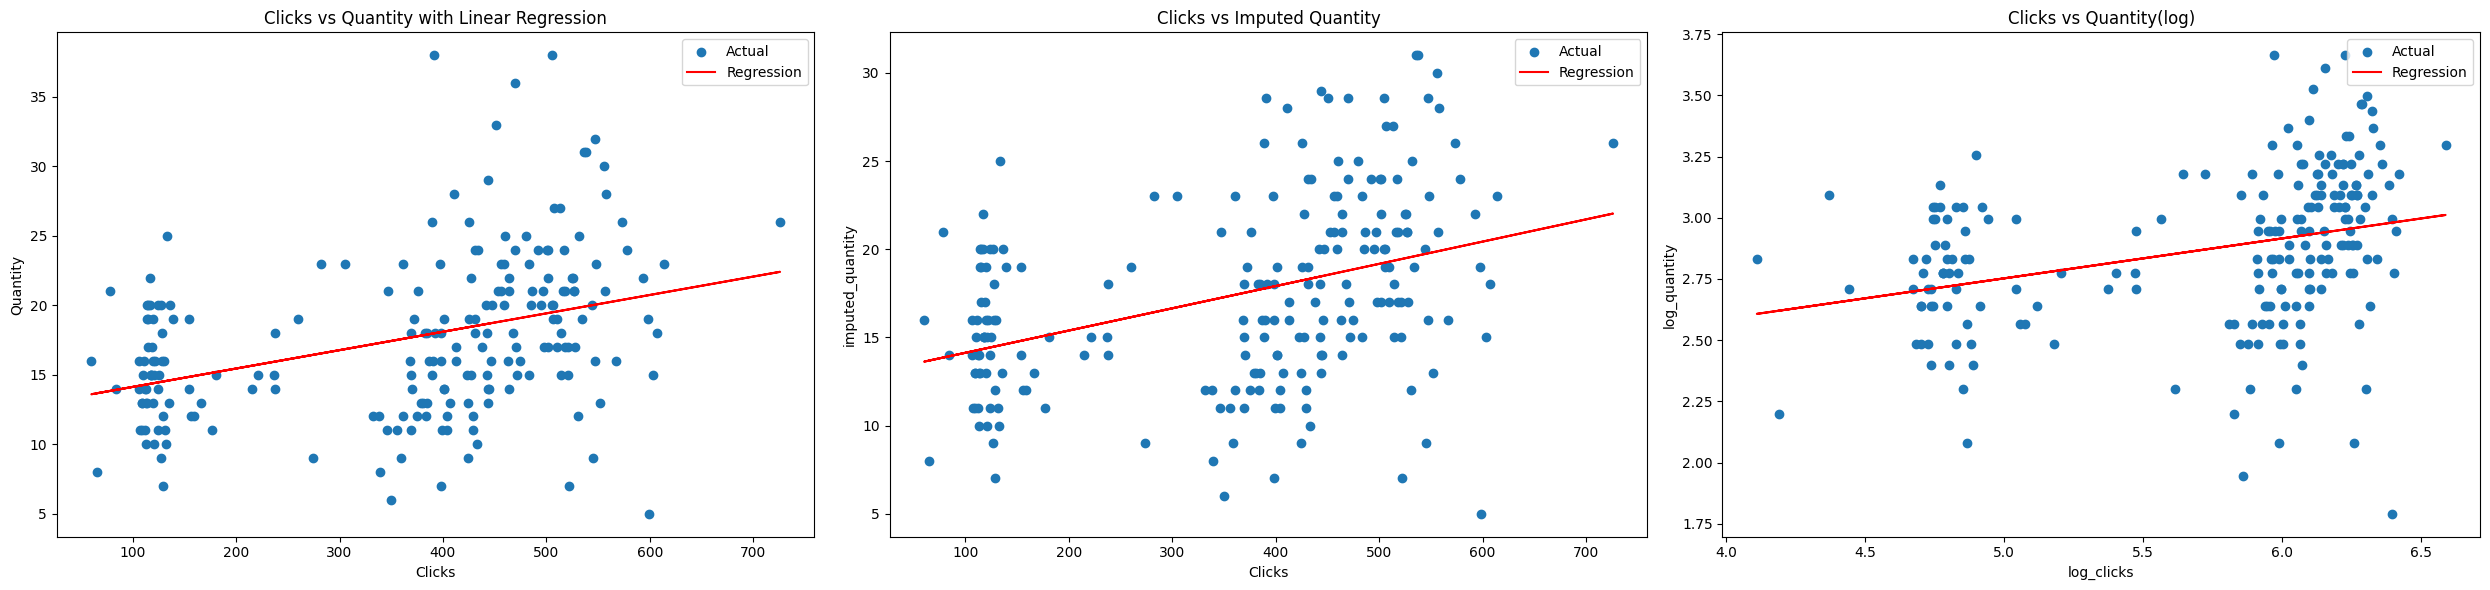

og:0.013234961483654805
imputed:0.012606614465075036
log:0.16298656613150664


In [461]:
#plotting
fig, axes = plt.subplots(1,3,figsize=(25,6))
og = regression(merged,'Clicks', 'Quantity', 'Clicks vs Quantity with Linear Regression',axes[0])
imputed = regression(merged,'Clicks', 'imputed_quantity', 'Clicks vs Imputed Quantity',axes[1])
log = regression(merged,'log_clicks', 'log_quantity', 'Clicks vs Quantity(log)',axes[2])
plt.tight_layout()
plt.show()
print(f"og:{og}")
print(f"imputed:{imputed}")
print(f"log:{log}")

- *Impressions affect the quantity*

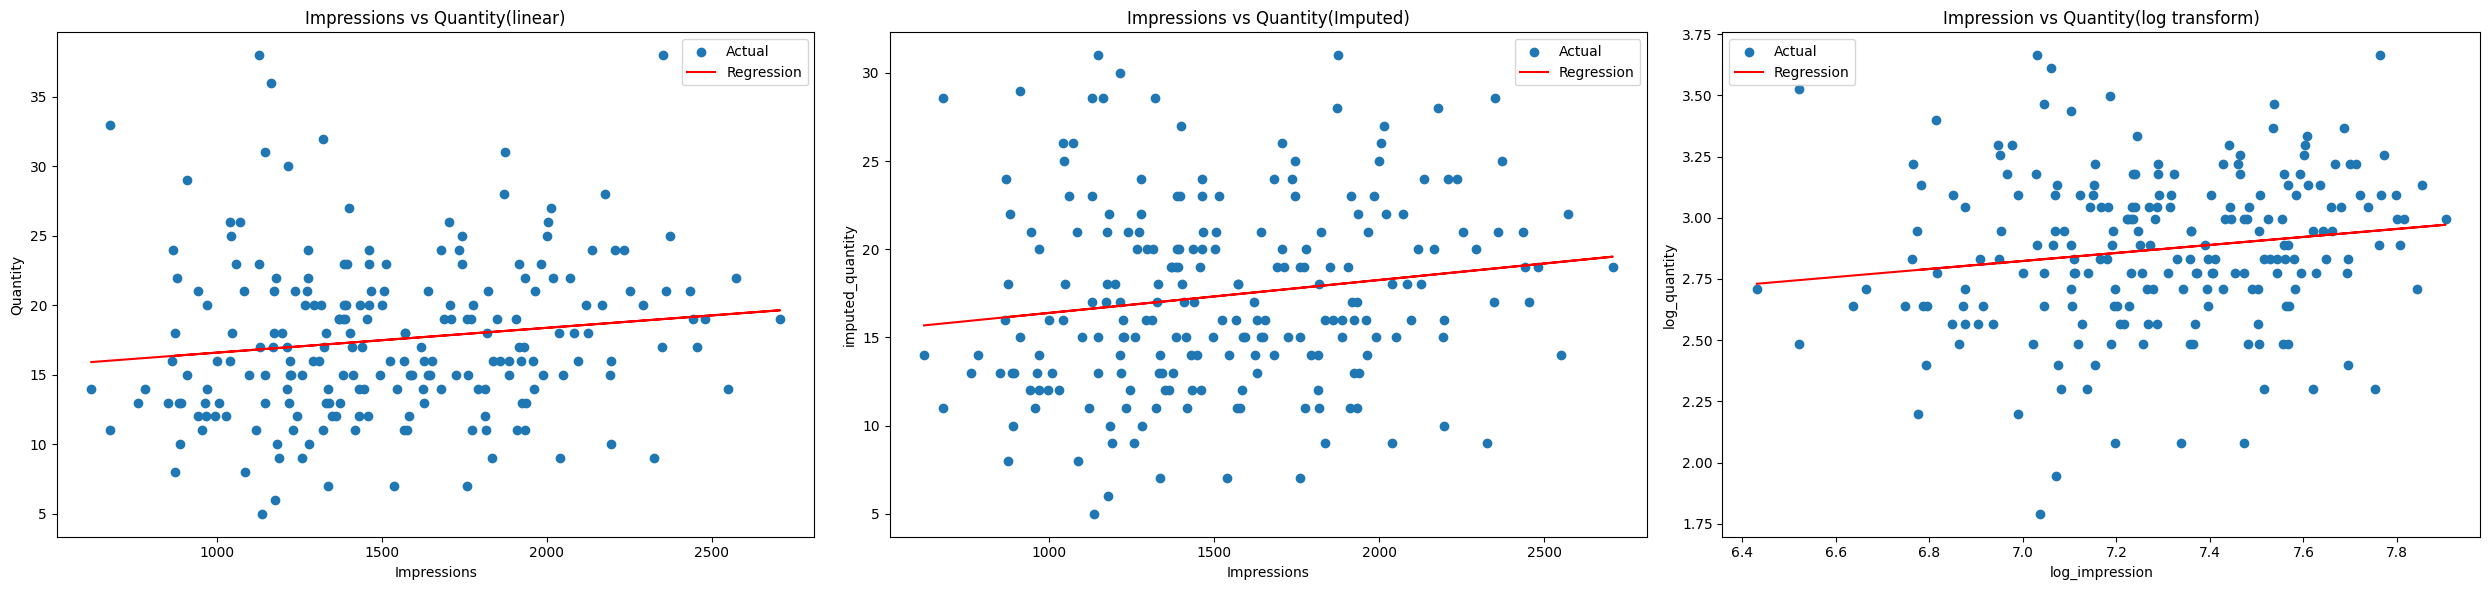

og: 0.0017863293104571235
imputed: 0.0018674999986826725
log: 0.16352913564679306


In [ ]:
fig,axes = plt.subplots(1,3,figsize=(25,6))
og = regression(merged, 'Impressions','Quantity','Impressions vs Quantity(linear)',axes[0] )
imputed = regression(merged,'Impressions', 'imputed_quantity','Impressions vs Quantity(Imputed)', axes[1])
log = regression(merged, 'log_impression','log_quantity', 'Impression vs Quantity(log transform)',axes[2])
plt.tight_layout()
plt.show()
print("og:",og)
print("imputed:",imputed)
print("log:",log)

- *Impression leads to more clicks*

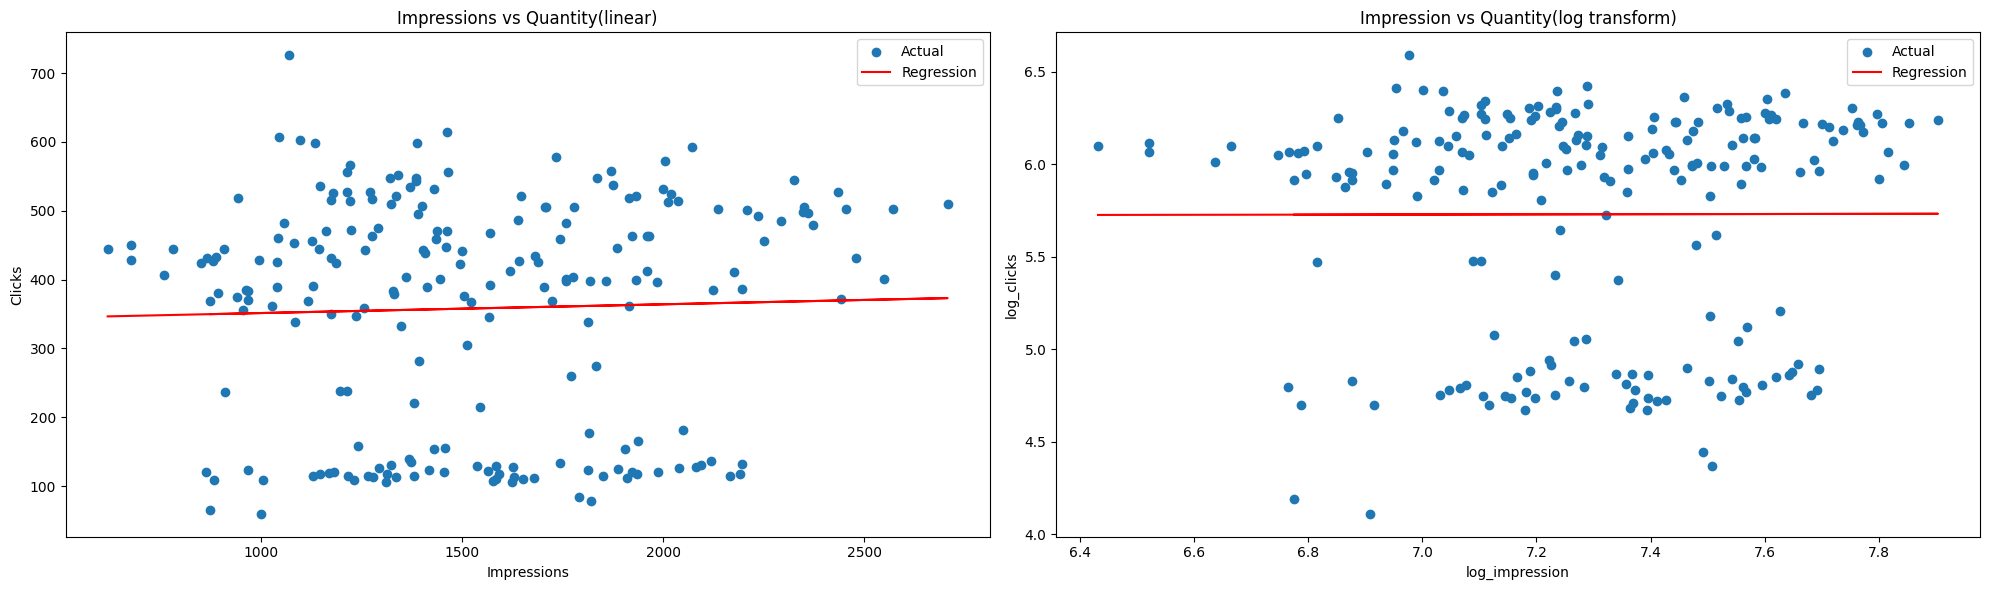

og: 0.012709310479620622
log: 0.004241626376529049


In [ ]:
fig,axes = plt.subplots(1,2,figsize=(20,6))
og = regression(merged, 'Impressions','Clicks','Impressions vs Quantity(linear)',axes[0] )
log = regression(merged, 'log_impression','log_clicks', 'Impression vs Quantity(log transform)',axes[1])
plt.tight_layout()
plt.show()
print("og:",og)
print("log:",log)

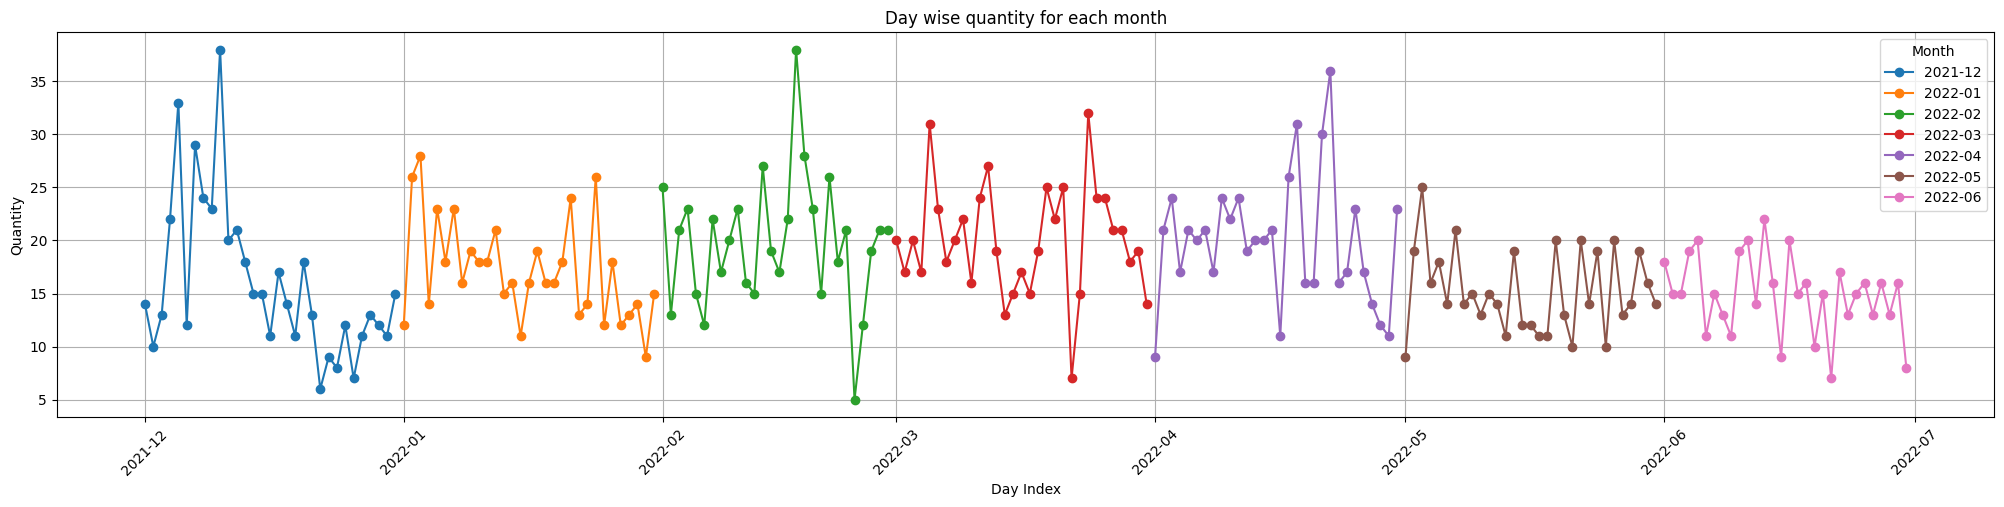

In [ ]:
# day_wise plot for all 7 months for quantity
plt.figure(figsize=(25,5))
for month in merged['ym'].unique():
    monthly_data = merged[merged['ym']==month]
    plt.plot(monthly_data['Day Index'],monthly_data['Quantity'],marker='o',label=str(month))
    
plt.title('Day wise quantity for each month')
plt.xlabel('Day Index')
plt.ylabel('Quantity')
plt.xticks(rotation=45)
plt.legend(title="Month",loc='best') 
plt.grid(True)
plt.show()  

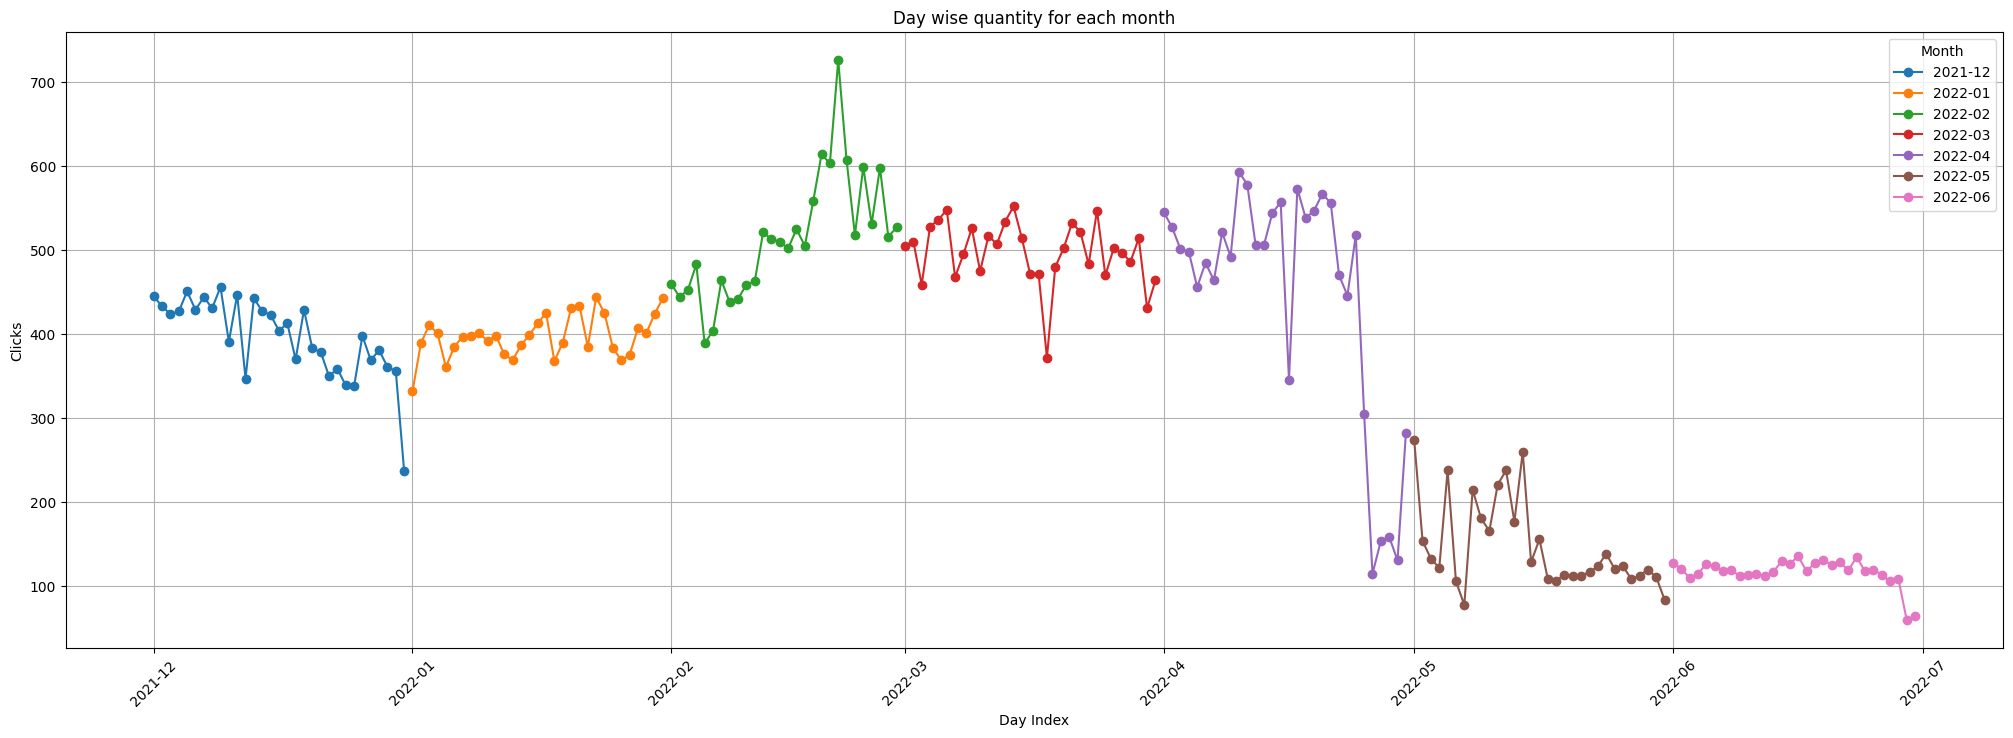

In [ ]:
#clicks
plt.figure(figsize=(25,8))
for month in merged['ym'].unique():
    monthly_data = merged[merged['ym']==month]
    plt.plot(monthly_data['Day Index'],monthly_data['Clicks'],marker='o',label=str(month))
    
plt.title('Day wise quantity for each month')
plt.xlabel('Day Index')
plt.ylabel('Clicks')
plt.xticks(rotation=45)
plt.legend(title="Month",loc='best') 
plt.grid(True)
plt.show()  

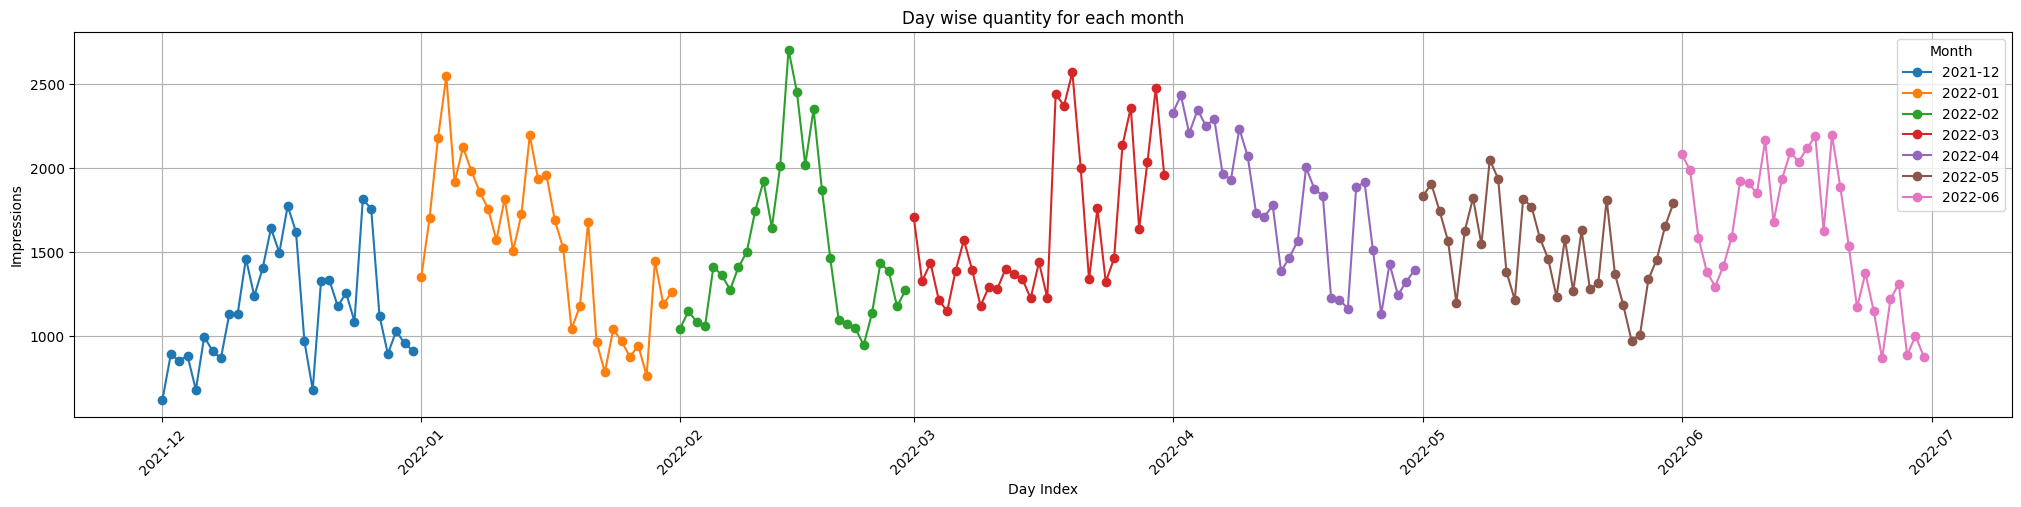

In [ ]:
#impression
plt.figure(figsize=(25,5))
for month in merged['ym'].unique():
    monthly_data = merged[merged['ym']==month]
    plt.plot(monthly_data['Day Index'],monthly_data['Impressions'],marker='o',label=str(month))
    
plt.title('Day wise quantity for each month')
plt.xlabel('Day Index')
plt.ylabel('Impressions')
plt.xticks(rotation=45)
plt.legend(title="Month",loc='best') 
plt.grid()
plt.show()   

**Monthly plot**

In [467]:
#quantity
def annotate(ax,x,y,values):
    for i, txt in enumerate(values):
        ax.annotate(f'{txt:.0f}',(x[i],y[i]),textcoords="offset points",xytext=(0,5),ha='center')

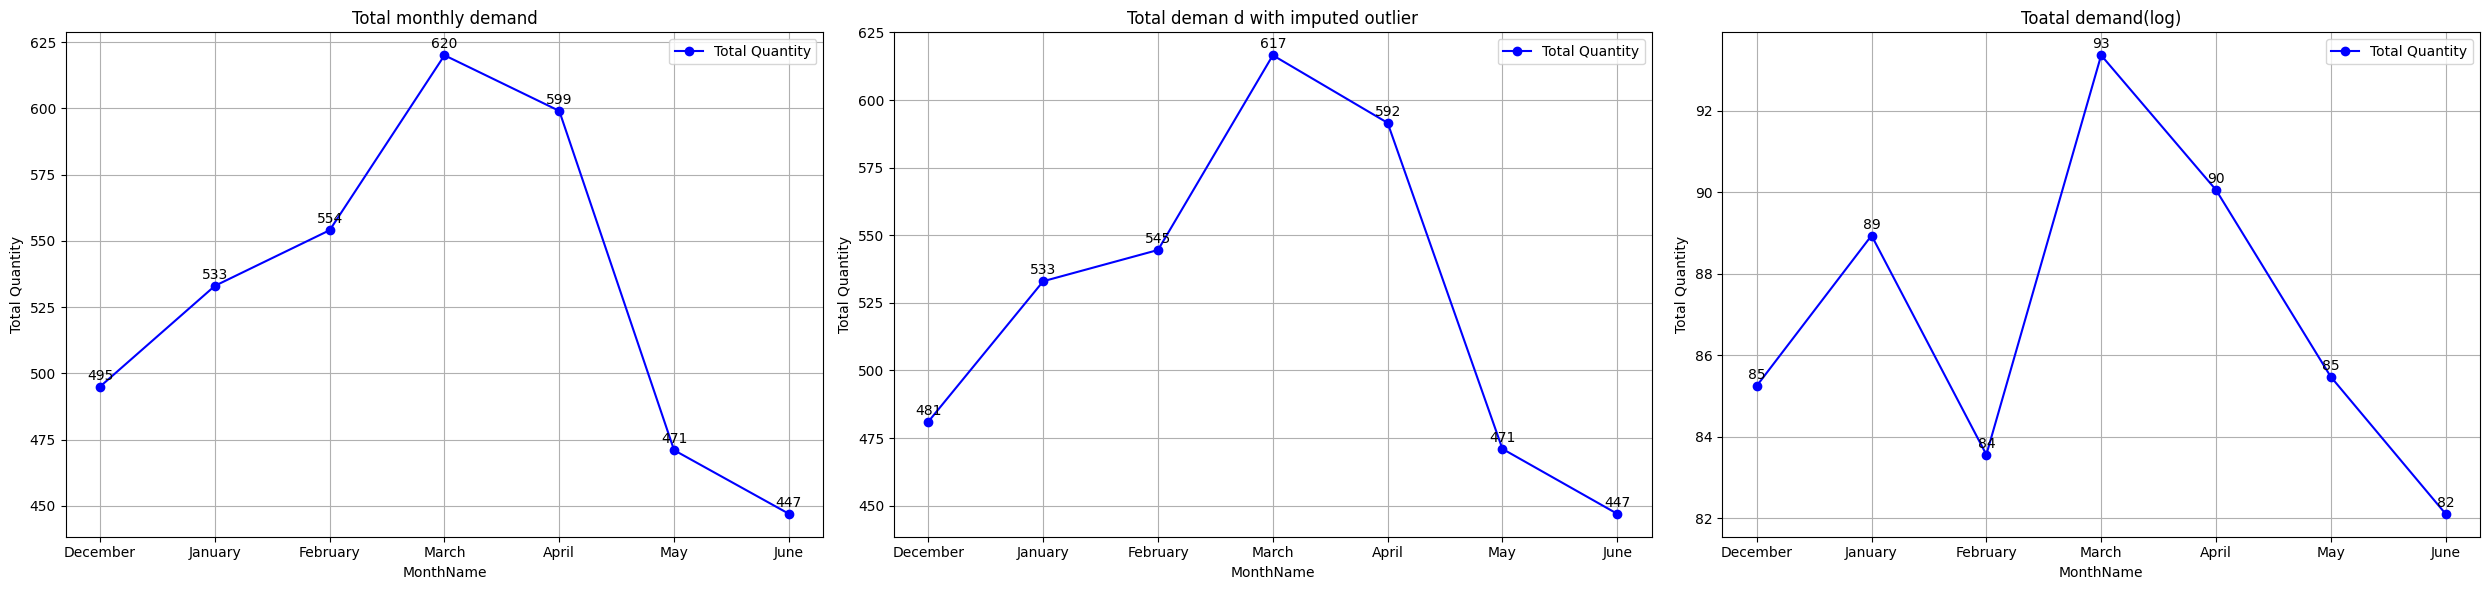

In [468]:
def plotMonthly(merged,x_col,y_col,title,ax):
    merged1 = merged.groupby(x_col,observed=False)[y_col].sum().reset_index()
    merged1 = merged1.sort_values(by=x_col)
    ax.plot(merged1[x_col],merged1[y_col],marker='o',color='blue',label="Total Quantity")
    annotate(ax,merged1[x_col],merged1[y_col],merged1[y_col])
    del merged1
    ax.set_title(title)
    ax.set_xlabel(x_col)
    ax.set_ylabel("Total Quantity")
    ax.grid(True)
    ax.legend()
    
#ploting side by side
fig,axes = plt.subplots(1,3,figsize=(25,6))
plotMonthly(merged,'MonthName','Quantity','Total monthly demand',axes[0])
plotMonthly(merged,'MonthName','imputed_quantity','Total deman d with imputed outlier',axes[1] )
plotMonthly(merged,'MonthName','log_quantity','Toatal demand(log)',axes[2])
plt.tight_layout()
plt.show()

*Hence the demand for the product increases in december (winter) arrives and reaches peak in march.*

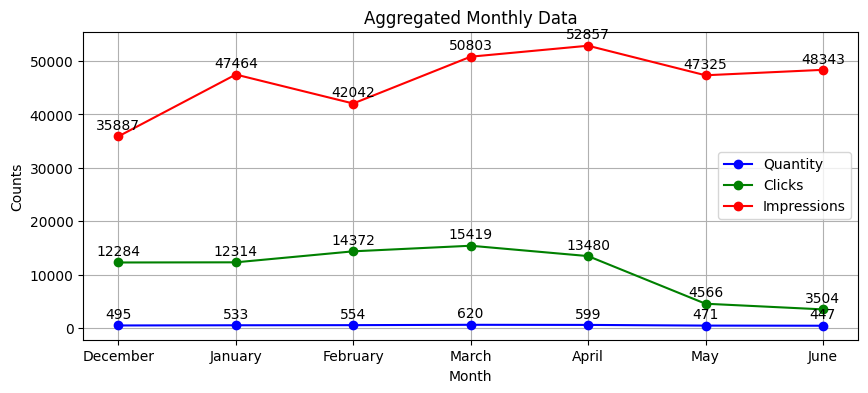

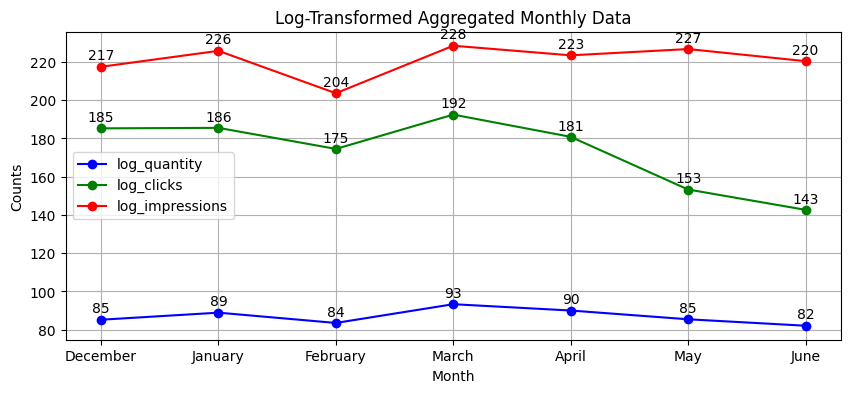

In [469]:
#for all
def plotAggregated(merged,x_col,y_cols,colors,labels,title):
    plt.figure(figsize=(10,4))
    ax=plt.gca()
    for y_col,color,label in zip(y_cols,colors,labels):
        merged1 = merged.groupby(x_col,observed=False)[y_col].sum().reset_index()
        merged1 = merged1.sort_values(by=x_col)
        ax.plot(merged1[x_col],merged1[y_col],marker='o',color=color,label=label)
        annotate(ax,merged1[x_col],merged1[y_col],merged1[y_col])
        del merged1
    ax.set_title(title)
    ax.set_xlabel('Month')
    ax.set_ylabel("Counts")
    ax.grid(True)
    ax.legend()
    plt.show()
    
plotAggregated(merged,'MonthName',['Quantity','Clicks','Impressions'],['blue','green','red'],['Quantity','Clicks','Impressions'],'Aggregated Monthly Data')
plotAggregated(merged,'MonthName',['log_quantity','log_clicks','log_impression'],['blue','green','red'],['log_quantity','log_clicks','log_impressions'],'Log-Transformed Aggregated Monthly Data')


- *We can see that there is a peak in march for all.*

### **Days of week plot**

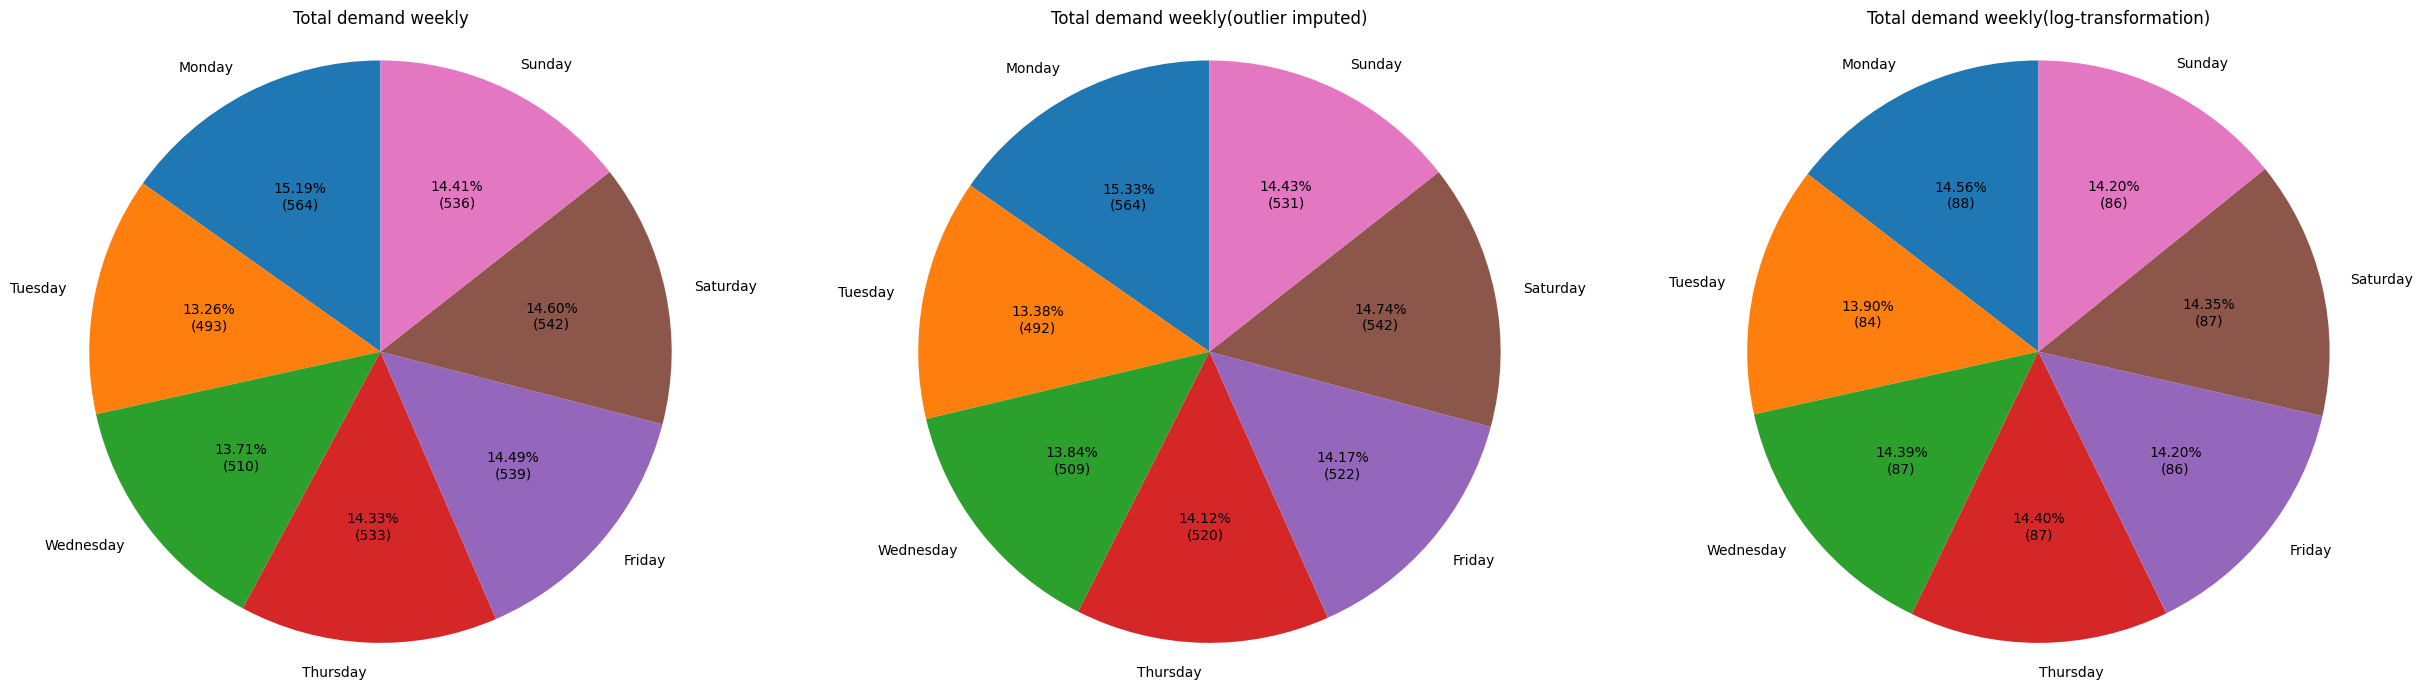

In [470]:
#quantity
def plotWeekly(merged,x_col,y_col,title,ax):
    merged1 = merged.groupby(x_col,observed=False)[y_col].sum().reset_index()
    merged1 = merged1.sort_values(by=x_col)
    labels = merged1[x_col]
    sizes = merged1[y_col]
    ax.pie(sizes,labels=labels,autopct=lambda pct: f'{pct:.2f}%\n({int(pct*sum(sizes)/100)})',startangle=90)
    ax.set_title(title)
    ax.axis('equal')
    del merged1
    
fig,axes = plt.subplots(1,3,figsize=(25,7))
plotWeekly(merged,'daysofweek','Quantity','Total demand weekly',axes[0])
plotWeekly(merged,'daysofweek','imputed_quantity','Total demand weekly(outlier imputed)',axes[1])
plotWeekly(merged,'daysofweek','log_quantity','Total demand weekly(log-transformation)',axes[2])
plt.tight_layout()
plt.show()

- *From we can say that monday is the peak of demand and tuesday is the lowest compared to all.*

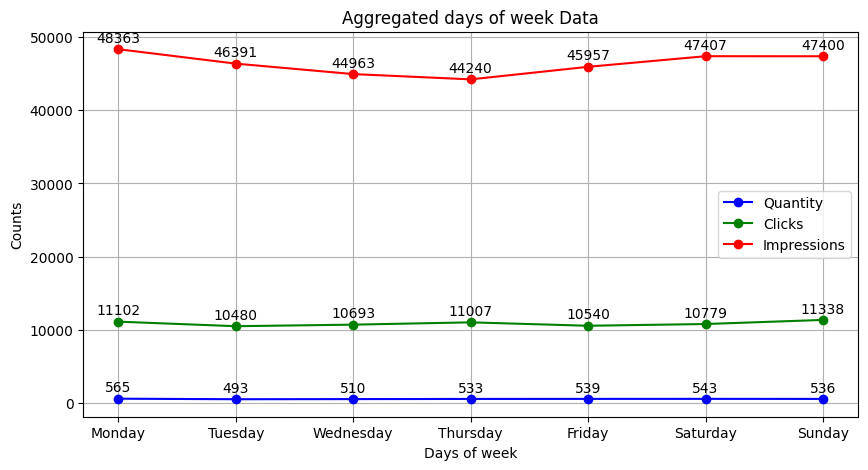

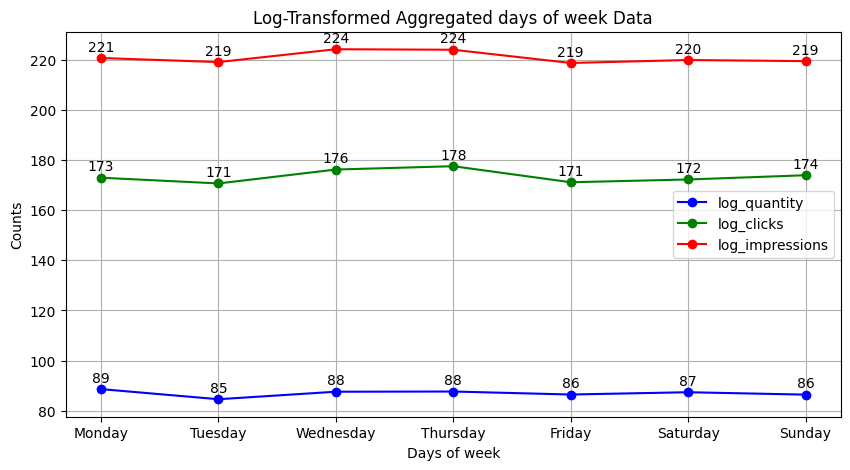

In [471]:
#for all
def plotAggregateds(merged,x_col,y_cols,colors,labels,title):
    plt.figure(figsize=(10,5))
    ax=plt.gca()
    for y_col,color,label in zip(y_cols,colors,labels):
        merged1 = merged.groupby(x_col,observed=False)[y_col].sum().reset_index()
        merged1 = merged1.sort_values(by=x_col)
        ax.plot(merged1[x_col],merged1[y_col],marker='o',color=color,label=label)
        annotate(ax,merged1[x_col],merged1[y_col],merged1[y_col])
        del merged1
    ax.set_title(title)
    ax.set_xlabel('Days of week')
    ax.set_ylabel("Counts")
    ax.grid(True)
    ax.legend()
    plt.show()
    
plotAggregateds(merged,'daysofweek',['Quantity','Clicks','Impressions'],['blue','green','red'],['Quantity','Clicks','Impressions'],'Aggregated days of week Data')
plotAggregateds(merged,'daysofweek',['log_quantity','log_clicks','log_impression'],['blue','green','red'],['log_quantity','log_clicks','log_impressions'],'Log-Transformed Aggregated days of week Data')


- *From original data we can say that weekends (saturday, sunday) and monday have high impressions and clicks and thursday for clicks.*

- *In log-transformed, wednesday and thursday have high clicks and impressions.*

### **Time Series Modelling**

In [502]:
master = r'C:\Users\Aravind S\Downloads\merged_data.xlsx'  # Added file name and closing quote
merged.to_excel(master, index=False)
print(f"Data saved successfully to {master}")

Data saved successfully to C:\Users\Aravind S\Downloads\merged_data.xlsx


In [473]:
master_data = pd.read_excel(r'C:\Users\Aravind S\Downloads\merged_data.xlsx')

In [474]:
# Function to check stationarity using Augmented Dickey-Fuller test
def check_stationarity(series):
    result = adfuller(series.dropna())
    print(f"ADF Statistic: {result[0]}")
    print(f"p-value: {result[1]}")
    return result[1] < 0.05  # If p-value < 0.05, it's stationary
# Check for stationarity of the 'Imputed_Quantity' column
is_stationary = check_stationarity(master_data['imputed_quantity'])
if not is_stationary:
    print("The series is non-stationary. Consider differencing or other transformations.")

ADF Statistic: -4.365375497923749
p-value: 0.0003416347702463317


*It is a stationary series as p-value less than 0.05*

In [475]:
# Convert 'Day Index' column to datetime
master_data['Day Index'] = pd.to_datetime(master_data['Day Index'], errors='coerce')
# Set 'Day Index' as the index for resampling
master_data.set_index('Day Index', inplace=True)

In [476]:
# Assuming 'merged' is the main DataFrame with the necessary columns
train_size = int(0.7 * len(merged))
# Define the train and test datasets for the target (dependent variable)
train = master_data['imputed_quantity'][:train_size]  # Added train_target
test = master_data['imputed_quantity'][train_size:]
train_exog = master_data[['Impressions', 'Clicks', 'MonthNum', 'weekOfMonth','Weekday_Monday', 'Weekday_Tuesday', 'Weekday_Wednesday', 'Weekday_Thursday', 'Weekday_Friday', 'Weekday_January', 'Weekday_February', 'Weekday_March', 'Weekday_April', 'Weekday_May', 'Weekday_June', 'Weekday_July', 'Weekday_August', 'Weekday_September', 'Weekday_October', 'Weekday_November', 'Weekday_December']][:train_size]
test_exog = master_data[['Impressions', 'Clicks', 'MonthNum', 'weekOfMonth','Weekday_Monday', 'Weekday_Tuesday', 'Weekday_Wednesday', 'Weekday_Thursday', 'Weekday_Friday', 'Weekday_January', 'Weekday_February', 'Weekday_March',  'Weekday_April', 'Weekday_May', 'Weekday_June',   'Weekday_July', 'Weekday_August', 'Weekday_September', 'Weekday_October', 'Weekday_November', 'Weekday_December']][train_size:]

In [477]:
trainsize = int(0.7 * len(merged))
#define the train and test
train = master_data['imputed_quantity'][:trainsize]
test = master_data['imputed_quantity'][trainsize:]
exogenouscolumns = ['Impressions', 'Clicks', 'MonthNum', 'weekOfMonth','Weekday_Monday', 'Weekday_Tuesday', 'Weekday_Wednesday', 'Weekday_Thursday', 'Weekday_Friday','Weekday_January', 'Weekday_February', 'Weekday_March', 'Weekday_April', 'Weekday_May', 'Weekday_June','Weekday_July', 'Weekday_August', 'Weekday_September', 'Weekday_October', 'Weekday_November', 'Weekday_December']
trainexog = master_data[exogenouscolumns][:trainsize] 
testexog = master_data[exogenouscolumns][trainsize:] 

In [478]:
# Helper function to calculate evaluation metrics
def calculate_metrics(true_values, predicted_values):
    mae = mean_absolute_error(true_values, predicted_values)
    rmse = np.sqrt(mean_squared_error(true_values, predicted_values))
    mse = mean_squared_error(true_values, predicted_values)
    mape = np.mean(np.abs((true_values - predicted_values) / true_values)) * 100
    return mae, rmse, mse, mape

In [479]:
def plot_model_predictions(true_values, predicted_values, model_name):
    # Make sure the Day Index is set as the index in masterdata
    plt.figure(figsize=(10, 6))
    # Plot true values and predicted values, using 'Day Index' (which is the index now)
    plt.plot(true_values.index, true_values, label='True values')
    plt.plot(true_values.index, predicted_values, label=f'{model_name} Predictions', color='orange')
    # Labeling the axes
    plt.xlabel("Day Index")  # Label the x-axis
    plt.ylabel("Imputed Quantity")  # Label the y-axis
    plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
    # Adding the legend and title
    plt.legend()
    plt.title(f'{model_name} Model Predictions')
    # Display the plot
    plt.show()


In [480]:
# Function to plot residuals
def plot_residuals(model_fit, model_name):
    residuals = model_fit.resid
    plt.figure(figsize=(10, 6))
    plt.plot(residuals, label='Residuals', color='purple')
    plt.axhline(0, linestyle='--', color='gray', linewidth=1)
    plt.title(f'Residual Plot for {model_name}')
    plt.legend()
    plt.show()


In [481]:
# Function to plot weekly comparison
def plot_weekly_comparison(true_values, predicted_values, model_name):
    # Resample the true values and predicted values by week and sum them
    true_weekly = true_values.resample('W').sum()
    predicted_weekly = pd.Series(predicted_values, index=true_values.index).resample('W').sum()
    # Plotting
    plt.figure(figsize=(10, 6))
    plt.plot(true_weekly.index, true_weekly, label='True Weekly Values', marker='o')
    plt.plot(predicted_weekly.index, predicted_weekly, label=f'{model_name} Weekly Predictions', marker='o', color='orange')
    # Labeling the axes
    plt.xlabel("Week")
    plt.ylabel("Sum of Imputed Quantity (Weekly)")
    plt.title(f'{model_name} Model Weekly Predictions')
    plt.xticks(rotation=45)  # Rotate x-axis labels if needed for readability
    # Adding the legend
    plt.legend()
    # Display the plot
    plt.grid(visible=True, linestyle='--', alpha=0.6)
    plt.show()

In [482]:
warnings.filterwarnings("ignore")

**AR MODEL**

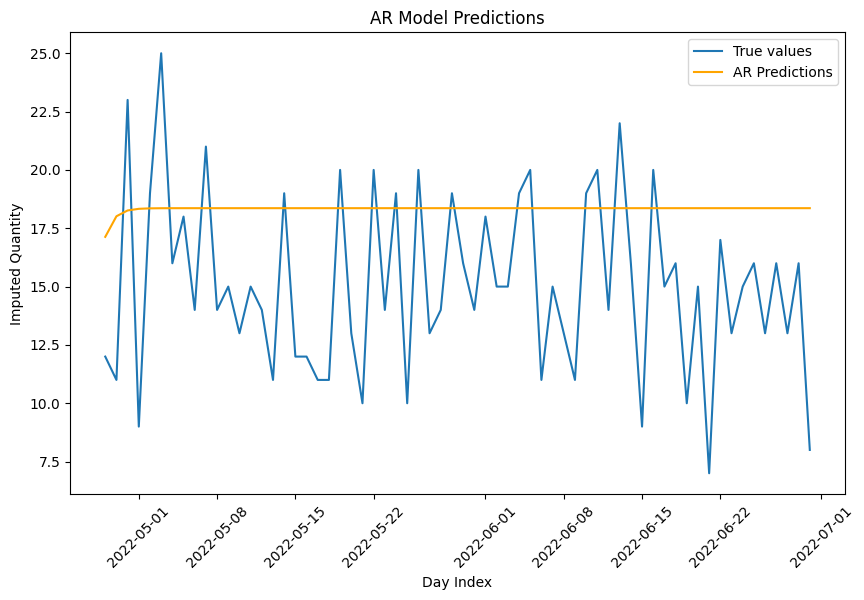

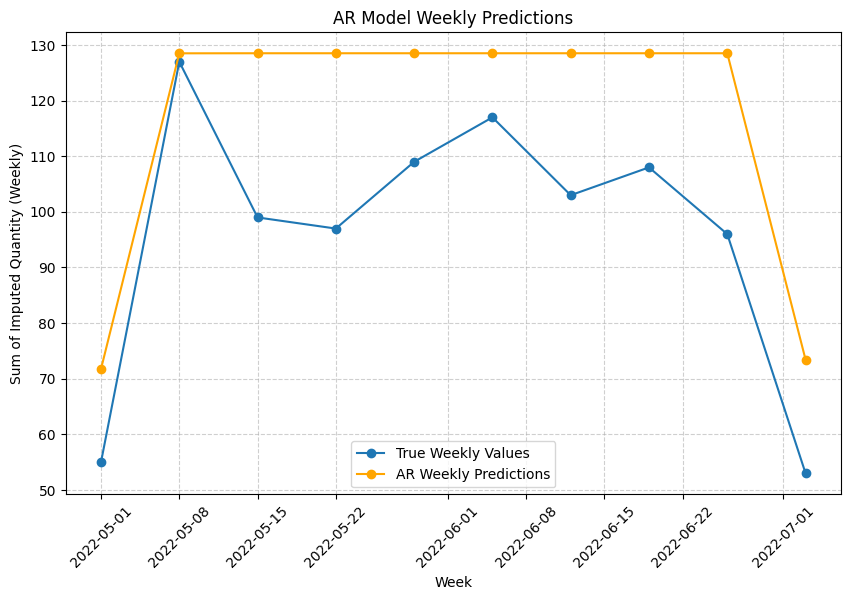

In [483]:
# ARIMA model (AR(1) model)
ar_model = ARIMA(train, order=(1, 0, 0))
ar_model_fit = ar_model.fit()
ar_predictions = ar_model_fit.forecast(len(test))
# Plot and Evaluate AR Model
plot_model_predictions(test, ar_predictions, "AR")
ar_metrics = calculate_metrics(test, ar_predictions)
# AR Model Weekly Plot
# Remove the datetime_index argument
plot_weekly_comparison(test, ar_predictions, "AR")

- *Poor performance of AR Mddel*

**MA MODEL**

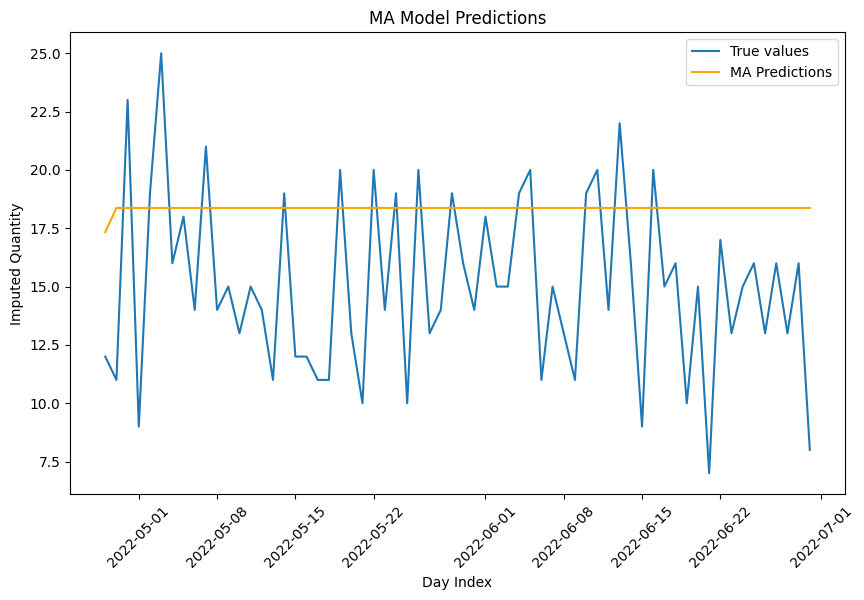

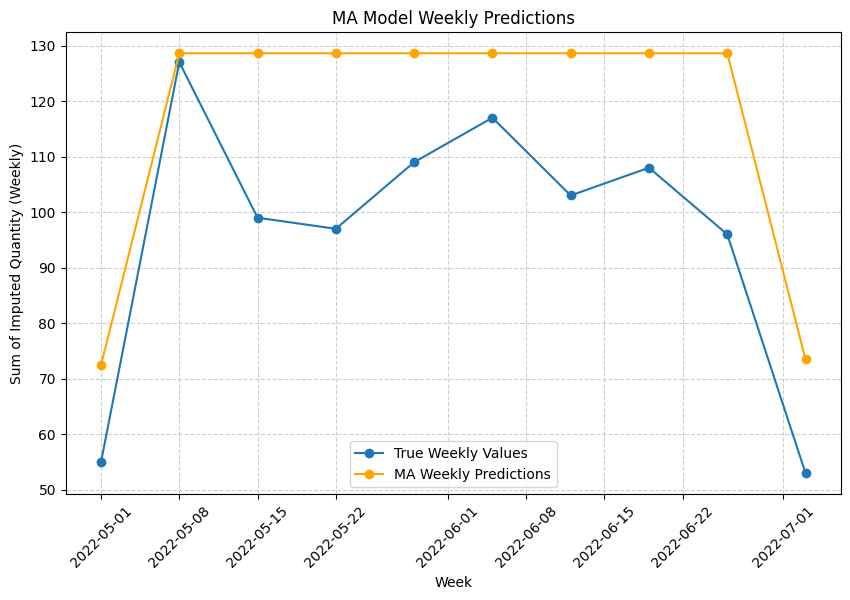

In [503]:
# Define the MA Model, fit it, and make predictions
ma_model = ARIMA(train, order=(0, 0, 1))  # Moving Average Model
ma_model_fit = ma_model.fit()  # Fit the model
ma_predictions = ma_model_fit.forecast(len(test))  # Forecast for test set
# Plot the MA Model Predictions
plot_model_predictions(test, ma_predictions, "MA")
# Calculate and display metrics for the MA Model
ma_metrics = calculate_metrics(test, ma_predictions)
# Plot Weekly Comparison for the MA Model
plot_weekly_comparison(test, ma_predictions, "MA")

- *Poor perforance of MA Model*

**ARIMA MODEL**

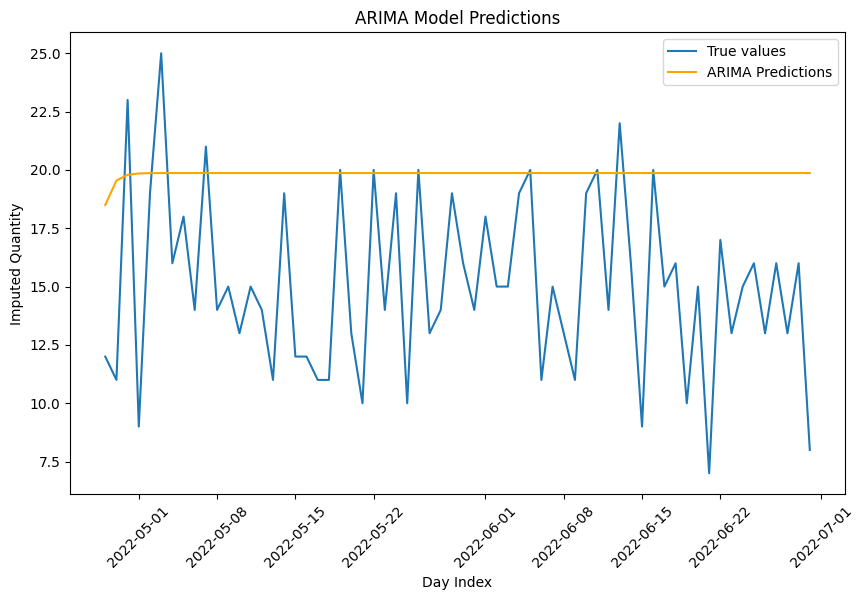

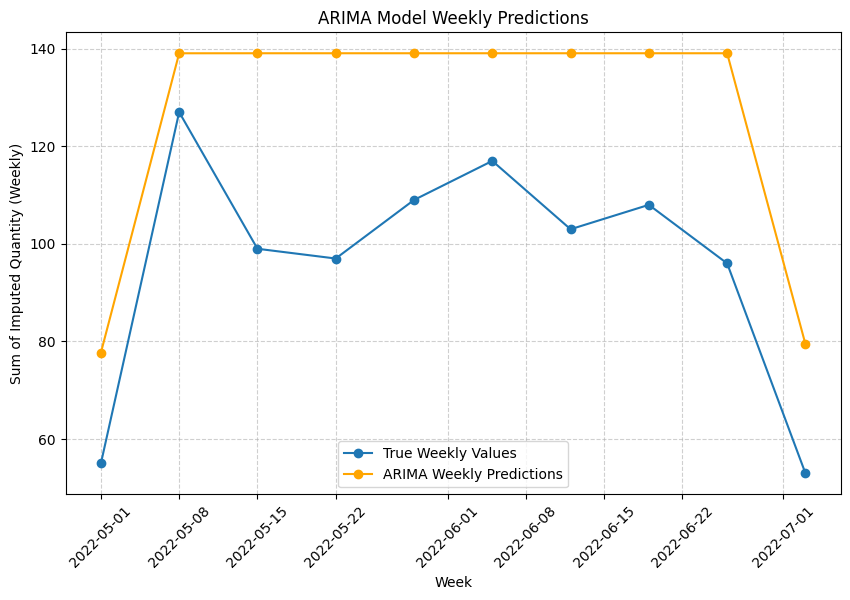

In [485]:
# ARIMA model (ARIMA(1, 1, 1) model)
arima_model = ARIMA(train, order=(1, 1, 1))
arima_model_fit = arima_model.fit()
arima_predictions = arima_model_fit.forecast(len(test))
# Plot and Evaluate ARIMA Model
plot_model_predictions(test, arima_predictions, "ARIMA")
arima_metrics = calculate_metrics(test, arima_predictions)
# ARIMA Model Weekly Plot
plot_weekly_comparison(test, arima_predictions, "ARIMA")

**HYPERPARAMETER TUNING ARIMA**

In [486]:
# ARIMA Hyperparameter Tuning
def objective_arima(trial):
    p = trial.suggest_int("p", 1, 5)
    d = trial.suggest_int("d", 0, 2)
    q = trial.suggest_int("q", 1, 5)
    # Fit ARIMA with trial parameters
    model = ARIMA(train, order=(p, d, q))
    model_fit = model.fit()
    predictions = model_fit.forecast(len(test))
    # Return RMSE as the objective metric
    return np.sqrt(mean_squared_error(test, predictions))
# Create Optuna study for ARIMA
study_arima = optuna.create_study(direction='minimize')
study_arima.optimize(objective_arima, n_trials=50)
best_arima_params = study_arima.best_params
# Print best ARIMA parameters
print("Best ARIMA Parameters:", best_arima_params)


[I 2024-12-05 00:48:13,966] A new study created in memory with name: no-name-2b915862-e8f6-412f-ad7f-d2581c2b6029
[I 2024-12-05 00:48:14,348] Trial 0 finished with value: 5.001726816500904 and parameters: {'p': 1, 'd': 0, 'q': 1}. Best is trial 0 with value: 5.001726816500904.
[I 2024-12-05 00:48:14,748] Trial 1 finished with value: 8.128090980699891 and parameters: {'p': 3, 'd': 2, 'q': 4}. Best is trial 0 with value: 5.001726816500904.
[I 2024-12-05 00:48:15,131] Trial 2 finished with value: 4.944869757011895 and parameters: {'p': 5, 'd': 0, 'q': 3}. Best is trial 2 with value: 4.944869757011895.
[I 2024-12-05 00:48:15,547] Trial 3 finished with value: 5.800177856698876 and parameters: {'p': 4, 'd': 1, 'q': 3}. Best is trial 2 with value: 4.944869757011895.
[I 2024-12-05 00:48:15,939] Trial 4 finished with value: 5.016091093773743 and parameters: {'p': 3, 'd': 0, 'q': 1}. Best is trial 2 with value: 4.944869757011895.
[I 2024-12-05 00:48:16,074] Trial 5 finished with value: 4.9985555

Best ARIMA Parameters: {'p': 5, 'd': 0, 'q': 3}


ARIMA Tuned Metrics: (np.float64(4.191813508514938), np.float64(4.944869757011895), np.float64(24.451736913810876), np.float64(34.419448620585))


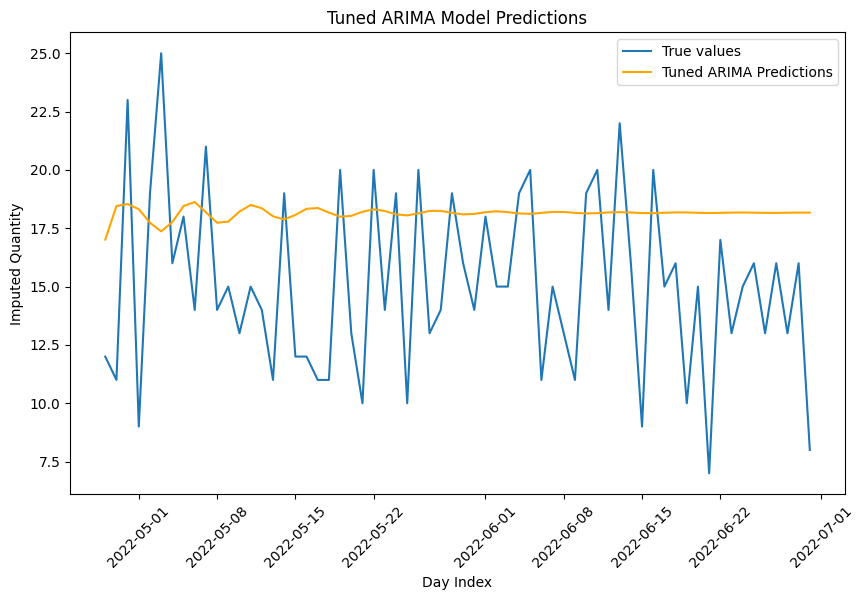

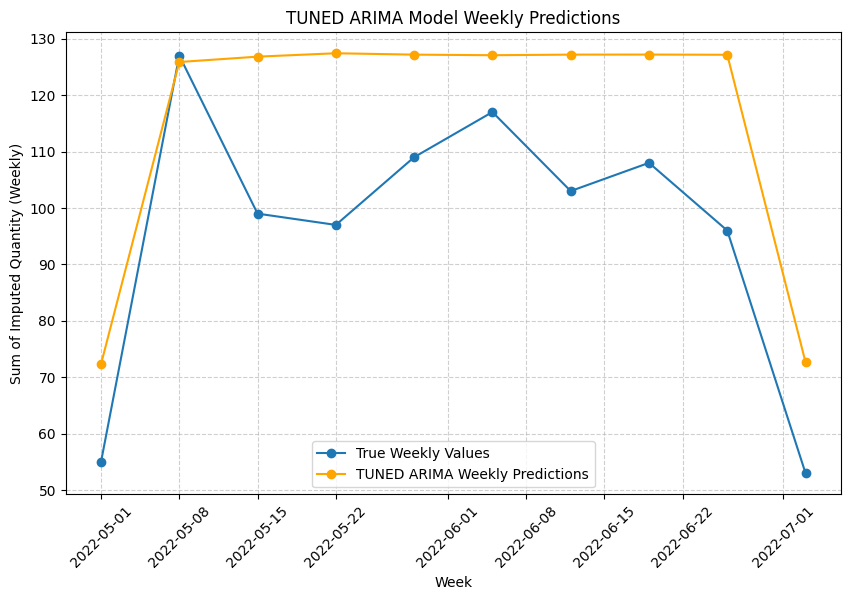

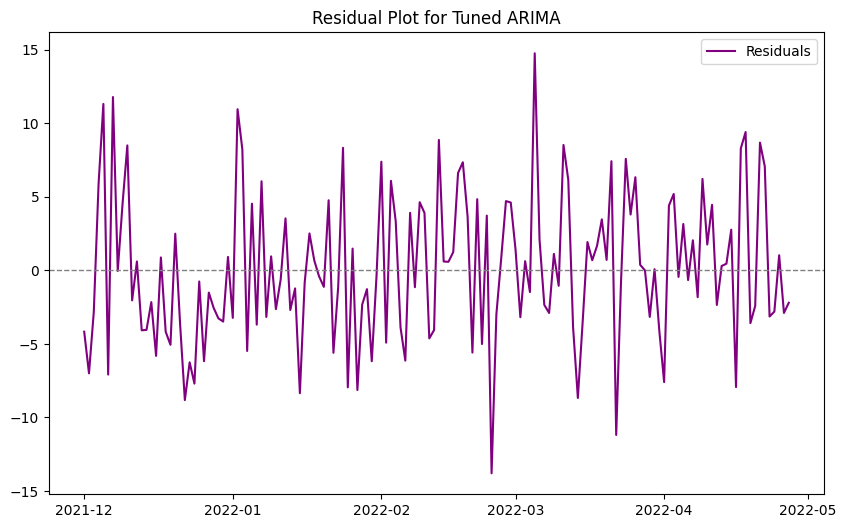

In [487]:
# Fit ARIMA with best parameters
arima_tuned_model = ARIMA(train,order=(best_arima_params['p'], best_arima_params['d'], best_arima_params['q']))
arima_tuned_model_fit = arima_tuned_model.fit()
# Predict with ARIMA tuned
arima_tuned_predictions = arima_tuned_model_fit.forecast(len(test))
# Evaluate ARIMA tuned
arima_tuned_metrics = calculate_metrics(test, arima_tuned_predictions)
print("ARIMA Tuned Metrics:", arima_tuned_metrics)
# Plot ARIMA tuned predictions
plot_model_predictions(test, arima_tuned_predictions, "Tuned ARIMA")
plot_weekly_comparison(test, arima_tuned_predictions, "TUNED ARIMA")
plot_residuals(arima_tuned_model_fit, "Tuned ARIMA")

**SARIMA MODEL**

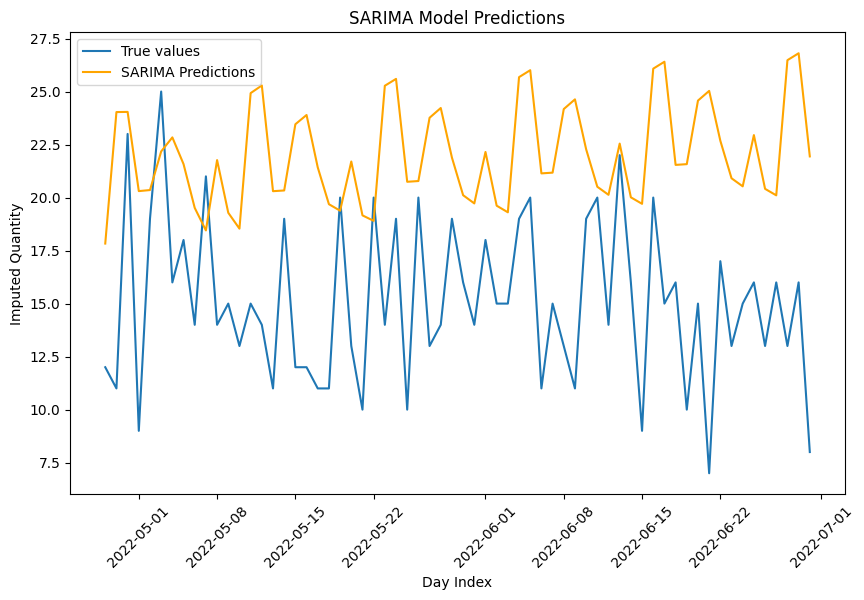

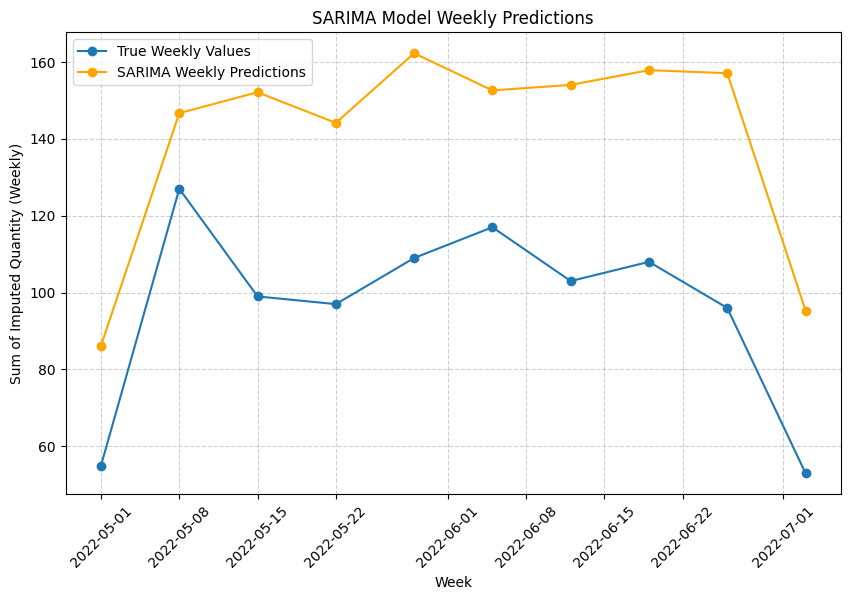

In [488]:
# SARIMA Model
sarima_model = SARIMAX(train, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
sarima_model_fit = sarima_model.fit()
sarima_predictions = sarima_model_fit.forecast(len(test))
# Plot and Evaluate SARIMA Model
plot_model_predictions(test, sarima_predictions, "SARIMA")
sarima_metrics = calculate_metrics(test, sarima_predictions)
# SARIMA Weekly Plot
plot_weekly_comparison(test, sarima_predictions, "SARIMA")

**SARIMA MODEL**

In [489]:
# SARIMA Hyperparameter Tuning
def objective_sarima(trial):
    p = trial.suggest_int("p", 1, 5)
    d = trial.suggest_int("d", 0, 2)
    q = trial.suggest_int("q", 1, 5)
    P = trial.suggest_int("P", 0, 2)
    D = trial.suggest_int("D", 0, 1)
    Q = trial.suggest_int("Q", 0, 2)
    s = 12  
    # Fixed seasonal period (monthly data)
    # Fit SARIMA with trial parameters
    model = SARIMAX(train,order=(p, d, q),seasonal_order=(P, D, Q, s))
    model_fit = model.fit()
    predictions = model_fit.forecast(len(test))
    # Return RMSE as the objective metric
    return np.sqrt(mean_squared_error(test, predictions))
# Create Optuna study for SARIMA
study_sarima = optuna.create_study(direction='minimize')
study_sarima.optimize(objective_sarima, n_trials=50)
best_sarima_params = study_sarima.best_params
# Print best SARIMA parameters
print("Best SARIMA Parameters:", best_sarima_params)

[I 2024-12-05 00:48:42,634] A new study created in memory with name: no-name-e6acb0ac-50f0-470a-8e52-46baab139a64
[I 2024-12-05 00:48:44,869] Trial 0 finished with value: 5.711464241049466 and parameters: {'p': 4, 'd': 0, 'q': 1, 'P': 2, 'D': 0, 'Q': 0}. Best is trial 0 with value: 5.711464241049466.
[I 2024-12-05 00:48:47,923] Trial 1 finished with value: 6.14799178548566 and parameters: {'p': 4, 'd': 0, 'q': 5, 'P': 0, 'D': 0, 'Q': 2}. Best is trial 0 with value: 5.711464241049466.
[I 2024-12-05 00:48:50,347] Trial 2 finished with value: 8.249493926836953 and parameters: {'p': 3, 'd': 2, 'q': 2, 'P': 1, 'D': 1, 'Q': 0}. Best is trial 0 with value: 5.711464241049466.
[I 2024-12-05 00:49:00,710] Trial 3 finished with value: 7.88724885512972 and parameters: {'p': 2, 'd': 2, 'q': 4, 'P': 2, 'D': 1, 'Q': 2}. Best is trial 0 with value: 5.711464241049466.
[I 2024-12-05 00:49:02,004] Trial 4 finished with value: 5.970038861901811 and parameters: {'p': 3, 'd': 1, 'q': 4, 'P': 1, 'D': 0, 'Q':

Best SARIMA Parameters: {'p': 4, 'd': 2, 'q': 1, 'P': 2, 'D': 0, 'Q': 0}


**HYPERPARAMETER TUNNING SARIMA**

SARIMA Tuned Metrics: (np.float64(4.013240673433688), np.float64(4.67719439846232), np.float64(21.876147441007305), np.float64(32.58678468570861))


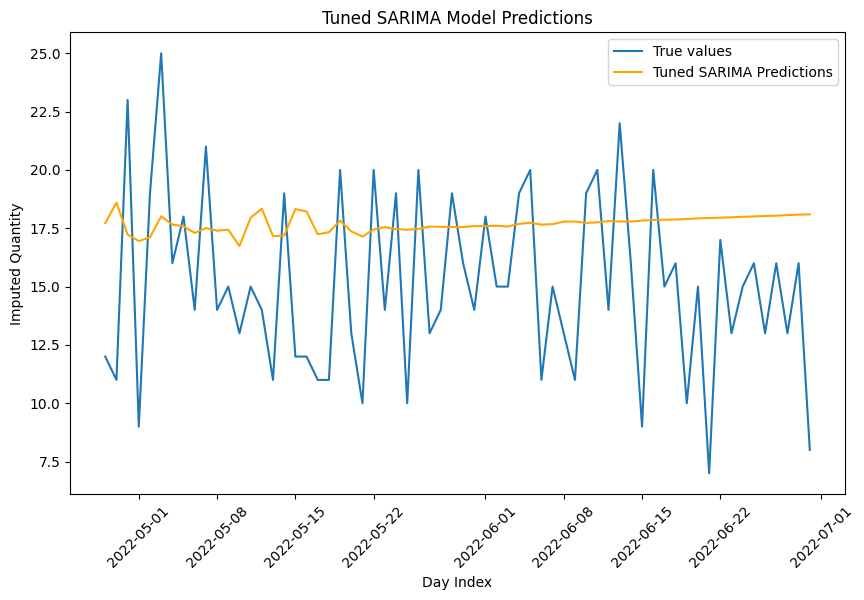

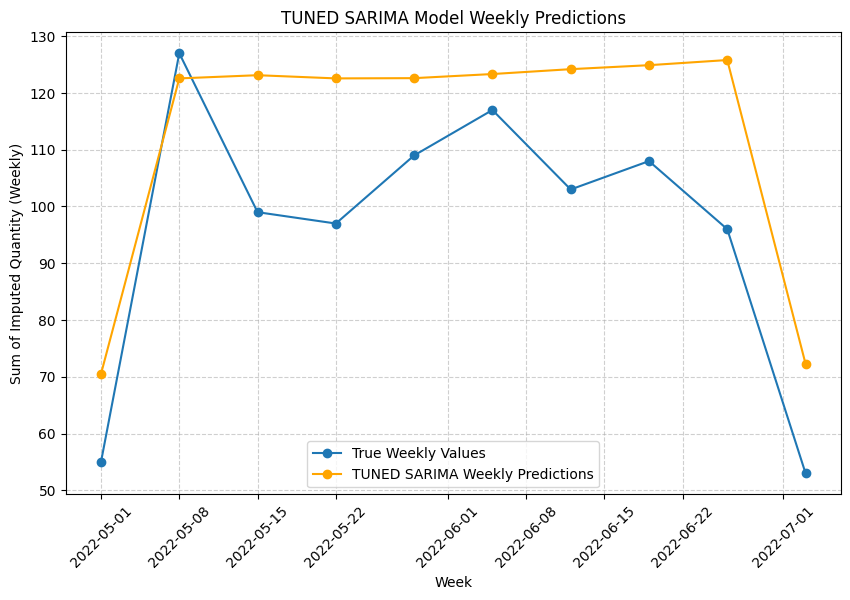

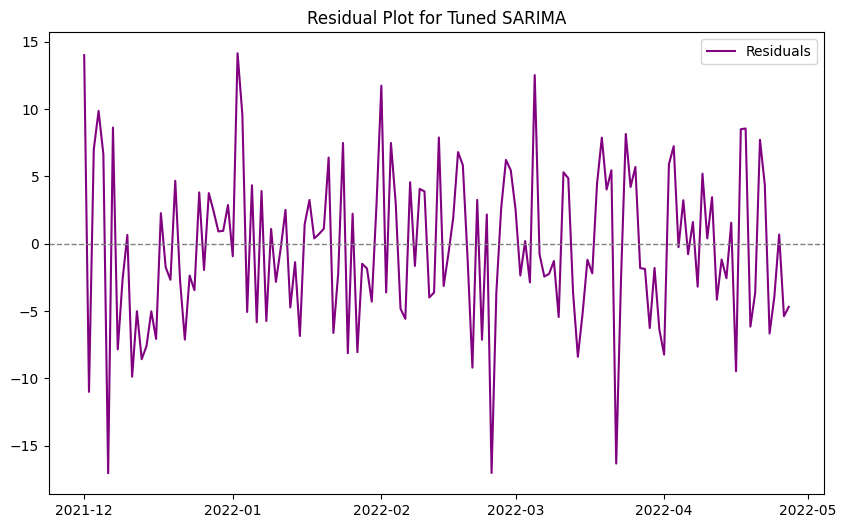

In [490]:
# Fit SARIMA with best parameters
sarima_tuned_model = SARIMAX(train,order=(best_sarima_params['p'], best_sarima_params['d'], best_sarima_params['q']),seasonal_order=(best_sarima_params['P'], best_sarima_params['D'], best_sarima_params['Q'], 12))
sarima_tuned_model_fit = sarima_tuned_model.fit()
# Predict with SARIMA tuned
sarima_tuned_predictions = sarima_tuned_model_fit.forecast(len(test))
# Evaluate SARIMA tuned
sarima_tuned_metrics = calculate_metrics(test, sarima_tuned_predictions)
print("SARIMA Tuned Metrics:", sarima_tuned_metrics)
# Plot SARIMA tuned predictions
plot_model_predictions(test, sarima_tuned_predictions, "Tuned SARIMA")
plot_weekly_comparison(test, sarima_tuned_predictions, "TUNED SARIMA")
plot_residuals(sarima_tuned_model_fit, "Tuned SARIMA")


**ARIMAX MODEL**

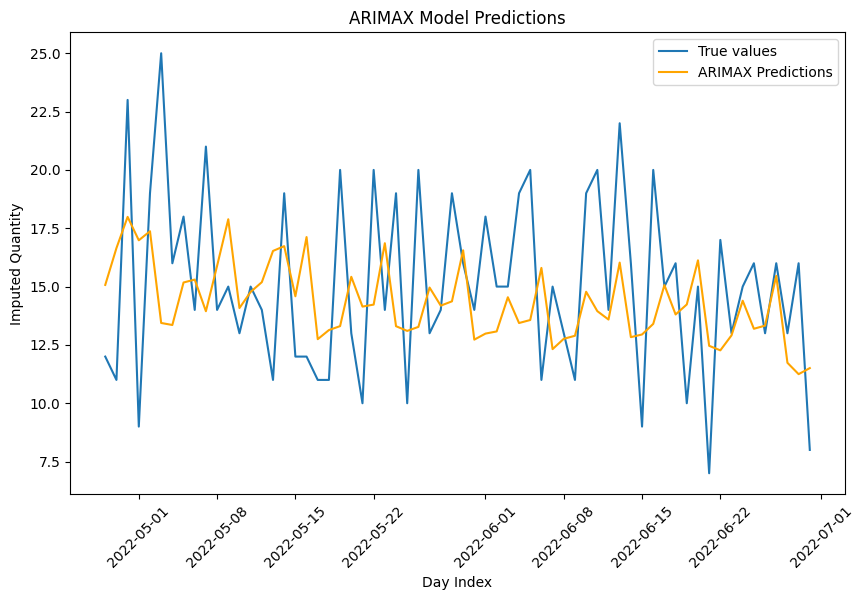

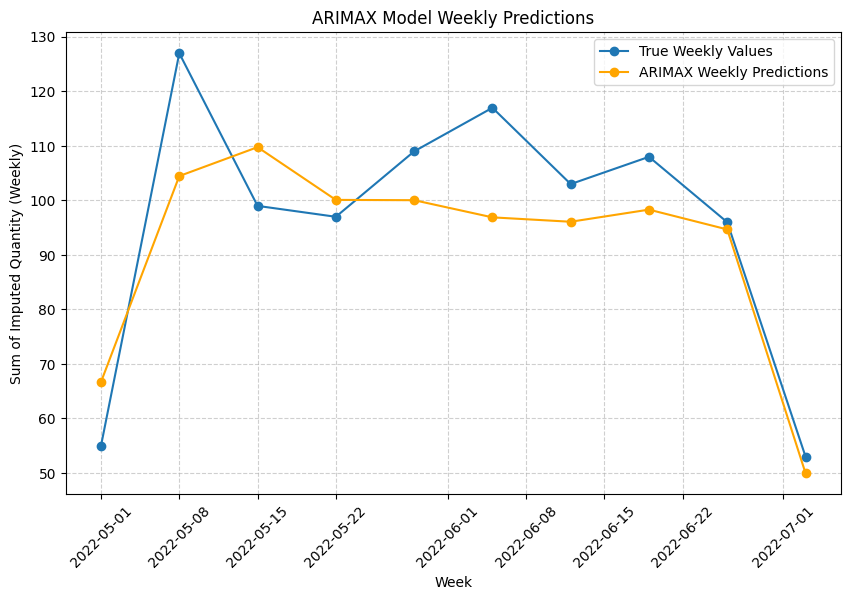

In [491]:
# ARIMAX Model with exogenous variables
arimax_model = ARIMA(train, order=(1, 1, 1), exog=train_exog)  # ARIMAX includes exogenous variables
arimax_model_fit = arimax_model.fit()
arimax_predictions = arimax_model_fit.forecast(len(test), exog=test_exog)
# Plotting the predictions
plot_model_predictions(test, arimax_predictions, "ARIMAX")
# Calculate metrics
arimax_metrics = calculate_metrics(test, arimax_predictions)
# Weekly comparison plot
plot_weekly_comparison(test, arimax_predictions, "ARIMAX")

**HYPERPARAMETER TUNNING ARIMAX** 

In [492]:
# ARIMAX Hyperparameter Tuning
def objective_arimax(trial):
    p = trial.suggest_int("p", 1, 5)
    d = trial.suggest_int("d", 0, 2)
    q = trial.suggest_int("q", 1, 5)
    # Fit ARIMAX model with trial parameters
    model = ARIMA(train, order=(p, d, q), exog=train_exog)
    model_fit = model.fit()
    predictions = model_fit.forecast(len(test), exog=test_exog)
    # Return RMSE as the objective metric
    return np.sqrt(mean_squared_error(test, predictions))
# Create Optuna study for ARIMAX
study_arimax = optuna.create_study(direction='minimize')
study_arimax.optimize(objective_arimax, n_trials=50)
best_arimax_params = study_arimax.best_params
# Print best ARIMAX parameters
print("Best ARIMAX Parameters:", best_arimax_params)


[I 2024-12-05 00:50:49,638] A new study created in memory with name: no-name-f9e35d91-151e-41e4-bc6d-cba83afd1e11
[I 2024-12-05 00:50:51,234] Trial 0 finished with value: 4.804839976910456 and parameters: {'p': 3, 'd': 0, 'q': 4}. Best is trial 0 with value: 4.804839976910456.
[I 2024-12-05 00:50:52,975] Trial 1 finished with value: 35.97523730207266 and parameters: {'p': 5, 'd': 2, 'q': 2}. Best is trial 0 with value: 4.804839976910456.
[I 2024-12-05 00:50:54,559] Trial 2 finished with value: 38.03772342721346 and parameters: {'p': 4, 'd': 2, 'q': 4}. Best is trial 0 with value: 4.804839976910456.
[I 2024-12-05 00:50:56,253] Trial 3 finished with value: 5.515762350051767 and parameters: {'p': 4, 'd': 1, 'q': 5}. Best is trial 0 with value: 4.804839976910456.
[I 2024-12-05 00:50:57,726] Trial 4 finished with value: 5.379666104504859 and parameters: {'p': 2, 'd': 1, 'q': 4}. Best is trial 0 with value: 4.804839976910456.
[I 2024-12-05 00:50:59,179] Trial 5 finished with value: 4.8521714

Best ARIMAX Parameters: {'p': 3, 'd': 0, 'q': 1}


ARIMAX Tuned Metrics: (np.float64(3.639891957839543), np.float64(4.646123669892265), np.float64(21.58646515593317), np.float64(23.074289860737395))


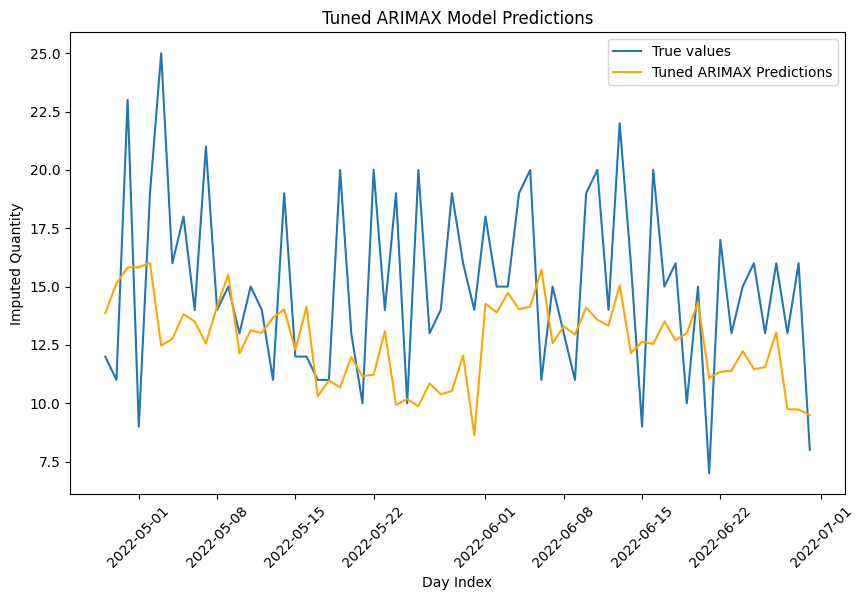

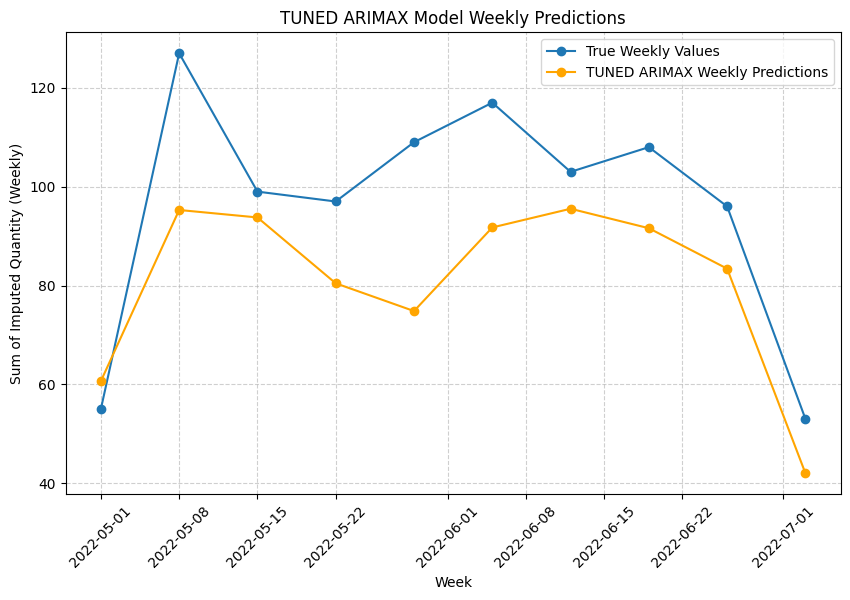

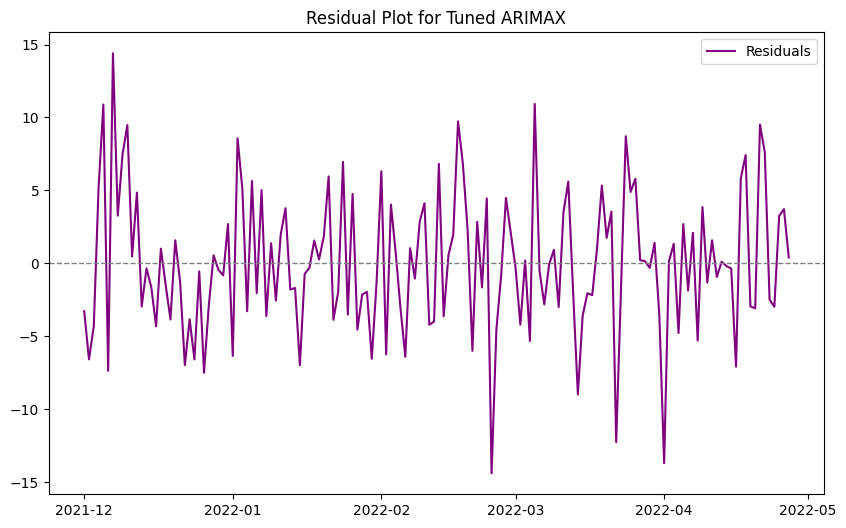

In [493]:
# Fit ARIMAX with best parameters
arimax_tuned_model = ARIMA(train,order=(best_arimax_params['p'], best_arimax_params['d'], best_arimax_params['q']),exog=train_exog)
arimax_tuned_model_fit = arimax_tuned_model.fit()
# Predict with ARIMAX tuned model
arimax_tuned_predictions = arimax_tuned_model_fit.forecast(len(test), exog=test_exog)
# Evaluate ARIMAX tuned model
arimax_tuned_metrics = calculate_metrics(test, arimax_tuned_predictions)
print("ARIMAX Tuned Metrics:", arimax_tuned_metrics)
# Plot ARIMAX tuned predictions
plot_model_predictions(test, arimax_tuned_predictions, "Tuned ARIMAX")
# Plot weekly comparison
plot_weekly_comparison(test, arimax_tuned_predictions, "TUNED ARIMAX")
# Plot residuals
plot_residuals(arimax_tuned_model_fit, "Tuned ARIMAX")

**SARIMAX MODEL**

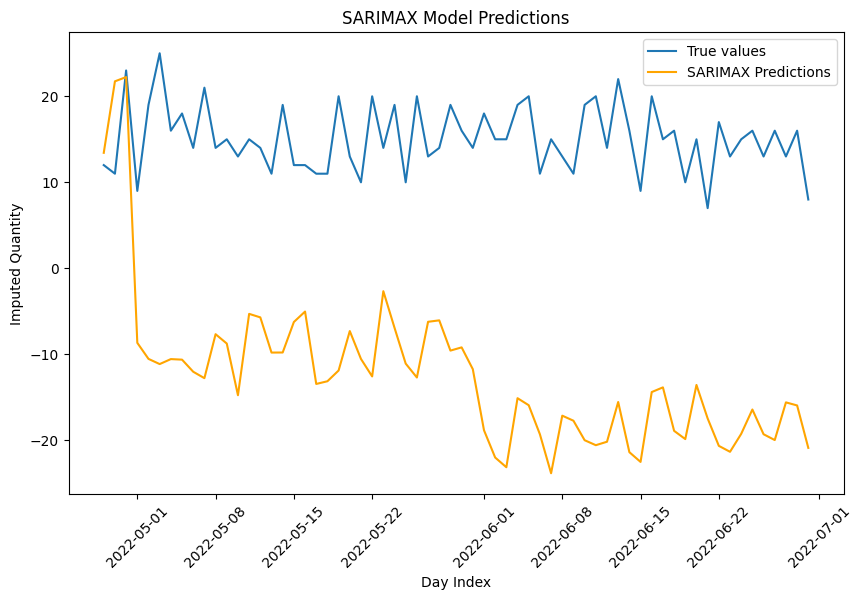

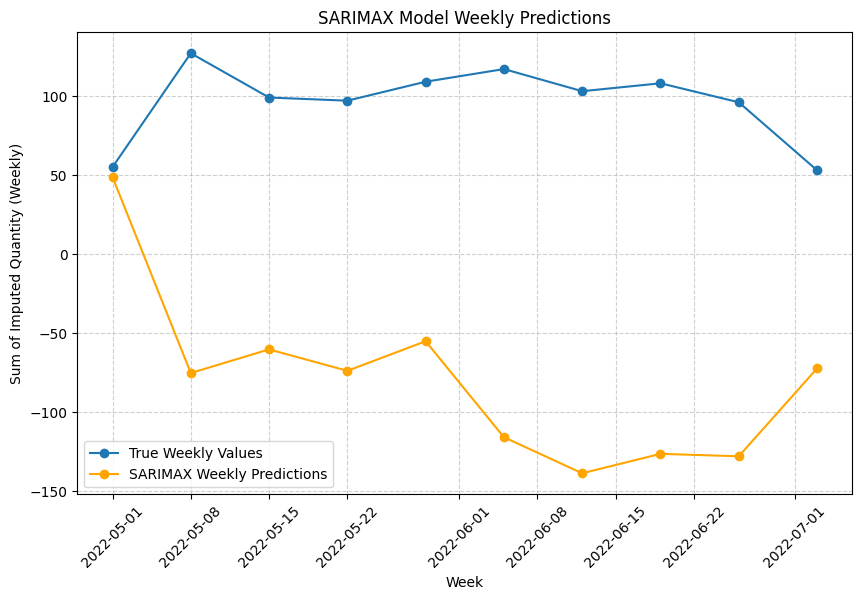

In [494]:
# Fit SARIMAX model with exogenous variables
sarimax_model = SARIMAX(train, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12), exog=train_exog)  
# SARIMAX includes exogenous variables
sarimax_model_fit = sarimax_model.fit()
# Predict with SARIMAX model
sarimax_predictions = sarimax_model_fit.forecast(len(test), exog=test_exog)
# Plotting the predictions
plot_model_predictions(test, sarimax_predictions, "SARIMAX")
# Calculate metrics
sarimax_metrics = calculate_metrics(test, sarimax_predictions)
# Plot weekly comparison
plot_weekly_comparison(test, sarimax_predictions, "SARIMAX")

**HYPERPARAMETER TUNNING SARIMAX**

In [495]:
# SARIMAX Hyperparameter Tuning
def objective_sarimax(trial):
    p = trial.suggest_int("p", 1, 5)
    d = trial.suggest_int("d", 0, 2)
    q = trial.suggest_int("q", 1, 5)
    P = trial.suggest_int("P", 0, 2)
    D = trial.suggest_int("D", 0, 1)
    Q = trial.suggest_int("Q", 0, 2)
    s = 12  # Fixed seasonal period (monthly data)
    # Fit SARIMAX with trial parameters
    model = SARIMAX(train,order=(p, d, q),seasonal_order=(P, D, Q, s),enforce_stationarity=True,enforce_invertibility=True,exog=train_exog)
    model_fit = model.fit()
    predictions = model_fit.forecast(len(test), exog=test_exog)
    # Return RMSE as the objective metric
    return np.sqrt(mean_squared_error(test, predictions))
# Create Optuna study for SARIMAX
study_sarimax = optuna.create_study(direction='minimize')
study_sarimax.optimize(objective_sarimax, n_trials=50)
# Get the best SARIMAX parameters
best_sarimax_params = study_sarimax.best_params
# Print best SARIMAX parameters
print("Best SARIMAX Parameters:", best_sarimax_params)

[I 2024-12-05 00:52:24,256] A new study created in memory with name: no-name-fd37a0c7-b4e3-4ae0-b70f-5c4eb1aa2af1
[I 2024-12-05 00:53:00,765] Trial 0 finished with value: 10.422294328880177 and parameters: {'p': 2, 'd': 2, 'q': 3, 'P': 1, 'D': 1, 'Q': 2}. Best is trial 0 with value: 10.422294328880177.
[I 2024-12-05 00:53:24,984] Trial 1 finished with value: 42.46865299312863 and parameters: {'p': 4, 'd': 2, 'q': 1, 'P': 1, 'D': 0, 'Q': 2}. Best is trial 0 with value: 10.422294328880177.
[I 2024-12-05 00:53:56,212] Trial 2 finished with value: 5.133634642071891 and parameters: {'p': 2, 'd': 0, 'q': 3, 'P': 2, 'D': 1, 'Q': 1}. Best is trial 2 with value: 5.133634642071891.
[I 2024-12-05 00:54:06,471] Trial 3 finished with value: 7.144668586431342 and parameters: {'p': 5, 'd': 0, 'q': 3, 'P': 1, 'D': 0, 'Q': 0}. Best is trial 2 with value: 5.133634642071891.
[I 2024-12-05 00:54:36,692] Trial 4 finished with value: 4.509852273678458 and parameters: {'p': 1, 'd': 0, 'q': 1, 'P': 1, 'D': 1,

Best SARIMAX Parameters: {'p': 1, 'd': 0, 'q': 3, 'P': 0, 'D': 1, 'Q': 1}


SARIMAX Tuned Metrics: (np.float64(3.498022628547642), np.float64(4.308941173550466), np.float64(18.566974037118467), np.float64(25.646944022913132))


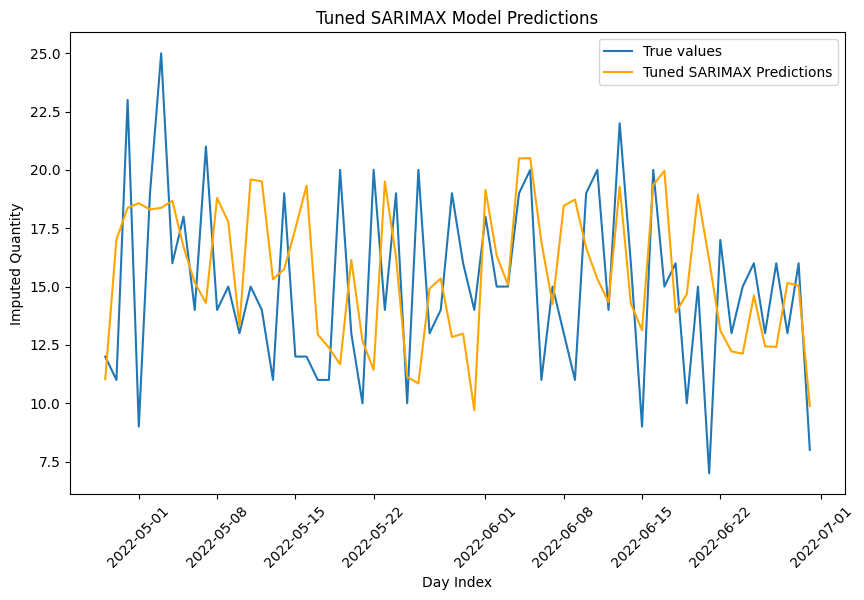

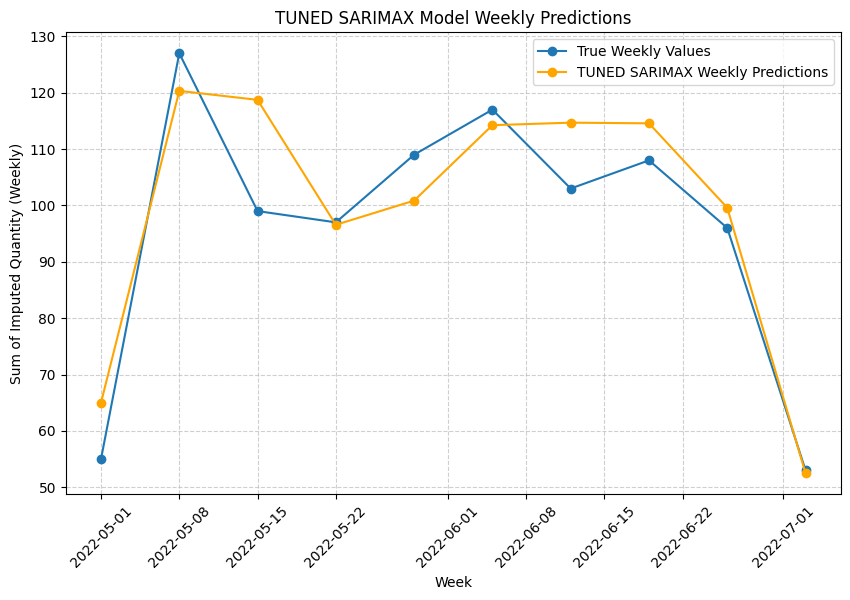

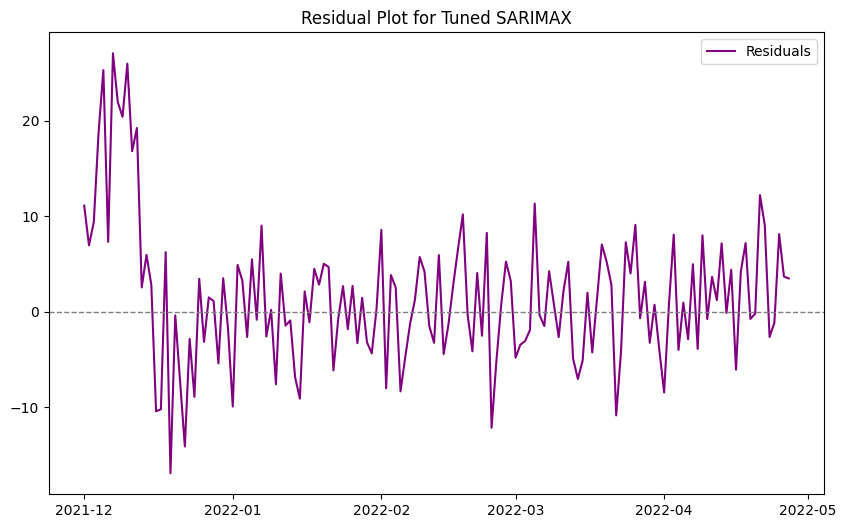

In [496]:
# Fit SARIMAX with best parameters
sarimax_tuned_model = SARIMAX(train,order=(best_sarimax_params['p'], best_sarimax_params['d'], best_sarimax_params['q']),seasonal_order=(best_sarimax_params['P'], best_sarimax_params['D'], best_sarimax_params['Q'], 12),exog=train_exog)
sarimax_tuned_model_fit = sarimax_tuned_model.fit()
# Predict with SARIMAX tuned model
sarimax_tuned_predictions = sarimax_tuned_model_fit.forecast(len(test), exog=test_exog)
# Evaluate SARIMAX tuned model
sarimax_tuned_metrics = calculate_metrics(test, sarimax_tuned_predictions)
print("SARIMAX Tuned Metrics:", sarimax_tuned_metrics)
# Plot SARIMAX tuned predictions
plot_model_predictions(test, sarimax_tuned_predictions, "Tuned SARIMAX")
# Plot Weekly Comparison for SARIMAX tuned model
plot_weekly_comparison(test, sarimax_tuned_predictions, "TUNED SARIMAX")
# Plot residuals for SARIMAX tuned model
plot_residuals(sarimax_tuned_model_fit, "Tuned SARIMAX")

- *Seasonality maximum captured.*
- *Residuals close to mid-value in Residual plot.*

**VALUES BEFORE TUNNING**

In [497]:
# Evaluation metrics before hyperparameter tuning
metrics_before = pd.DataFrame({"Model": ["AR", "MA", "ARIMA", "SARIMA", "ARIMAX", "SARIMAX"],"MAE": [ar_metrics[0], ma_metrics[0], arima_metrics[0], sarima_metrics[0], arimax_metrics[0], sarimax_metrics[0]],"MSE": [ar_metrics[2], ma_metrics[2], arima_metrics[2], sarima_metrics[2], arimax_metrics[2], sarima_metrics[2]],"MAPE": [ar_metrics[3], ma_metrics[3], arima_metrics[3], sarima_metrics[3], arimax_metrics[3], sarima_metrics[3]],})
# Display metrics before tuning
print("Metrics Before Tuning")
print(metrics_before)

Metrics Before Tuning
     Model        MAE        MSE       MAPE
0       AR   4.250673  25.300653  35.067471
1       MA   4.263641  25.479036  35.192884
2    ARIMA   5.163597  37.395990  42.898665
3   SARIMA   7.163901  67.200681  57.439626
4   ARIMAX   3.319975  16.619163  22.923059
5  SARIMAX  27.893108  67.200681  57.439626


- *Lower RMSE for R and MA models.*
- *Highest RMSE for SARIMAX model.*

**VALUES AFTER TUNNING**

In [498]:
# Create table for evaluation metrics after tuning
metrics_after = pd.DataFrame({"Model": ["AR", "MA", "ARIMA", "SARIMA", "ARIMAX", "SARIMAX"],"MAE": [ar_metrics[0], ma_metrics[0], arima_metrics[0], sarima_metrics[0], arimax_tuned_metrics[0], sarimax_tuned_metrics[0]],"RMSE": [ar_metrics[1], ma_metrics[1], arima_metrics[1], sarima_metrics[1], arimax_tuned_metrics[1], sarimax_tuned_metrics[1]],"MSE": [ar_metrics[2], ma_metrics[2], arima_metrics[2], sarima_metrics[2], arimax_tuned_metrics[2], sarimax_tuned_metrics[2]],"MAPE": [ar_metrics[3], ma_metrics[3], arima_metrics[3], sarima_metrics[3], arimax_tuned_metrics[3], sarimax_tuned_metrics[3]],})
# Display evaluation metrics after tuning
print("Evaluation Metrics After Hyperparameter Tuning")
print(metrics_after)

Evaluation Metrics After Hyperparameter Tuning
     Model       MAE      RMSE        MSE       MAPE
0       AR  4.250673  5.029975  25.300653  35.067471
1       MA  4.263641  5.047676  25.479036  35.192884
2    ARIMA  5.163597  6.115226  37.395990  42.898665
3   SARIMA  7.163901  8.197602  67.200681  57.439626
4   ARIMAX  3.639892  4.646124  21.586465  23.074290
5  SARIMAX  3.498023  4.308941  18.566974  25.646944


- *Highest RMSE for SARIMA*
- *Lower RMSE for SARIMAX*

- **Conclusion**
    - *SARIMAX captures more effectively so it is used for future analysis*.

**MULTIVARIATE REGRESSION(DYNAMIC)**

In [499]:
final = pd.read_excel(r'C:\Users\Aravind S\Downloads\merged_data.xlsx')

In [500]:

def plot_weekly_comparisons(true_values, predicted_values, date_index, model_name):

    # Create the weekly resampling of the data using 'Day Index'
    true_weekly = true_values.resample('W').sum()
    predicted_weekly = pd.Series(predicted_values, index=date_index).resample('W').sum()

    # Plotting
    plt.figure(figsize=(10, 6))
    plt.plot(true_weekly.index, true_weekly, label='True Weekly Values', marker='o')
    plt.plot(predicted_weekly.index, predicted_weekly, label=f'{model_name} Weekly Predictions', marker='o', color='orange')

    # Labeling the axes
    plt.xlabel("Week")
    plt.ylabel("Sum of Imputed Quantity (Weekly)")
    plt.title(f'{model_name} Model Weekly Predictions')
    plt.xticks(rotation=45)  # Rotate x-axis labels if needed for readability

    # Adding the legend
    plt.legend()

    # Display the plot
    plt.grid(visible=True, linestyle='--', alpha=0.6)

                              OLS Regression Results                              
Dep. Variable:     imputed_quantity_lag_1   R-squared:                       0.239
Model:                                OLS   Adj. R-squared:                  0.169
Method:                     Least Squares   F-statistic:                     3.407
Date:                    Thu, 05 Dec 2024   Prob (F-statistic):           8.36e-05
Time:                            01:10:18   Log-Likelihood:                -500.03
No. Observations:                     167   AIC:                             1030.
Df Residuals:                         152   BIC:                             1077.
Df Model:                              14                                         
Covariance Type:                nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------

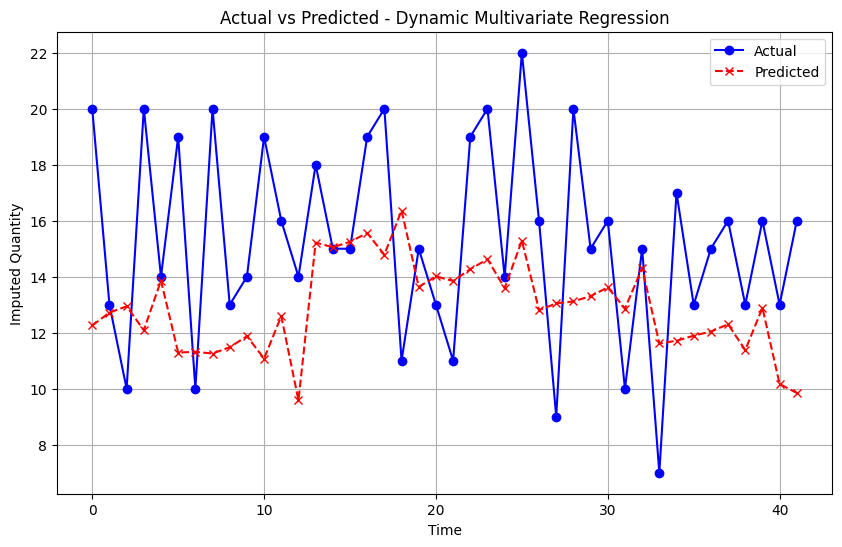

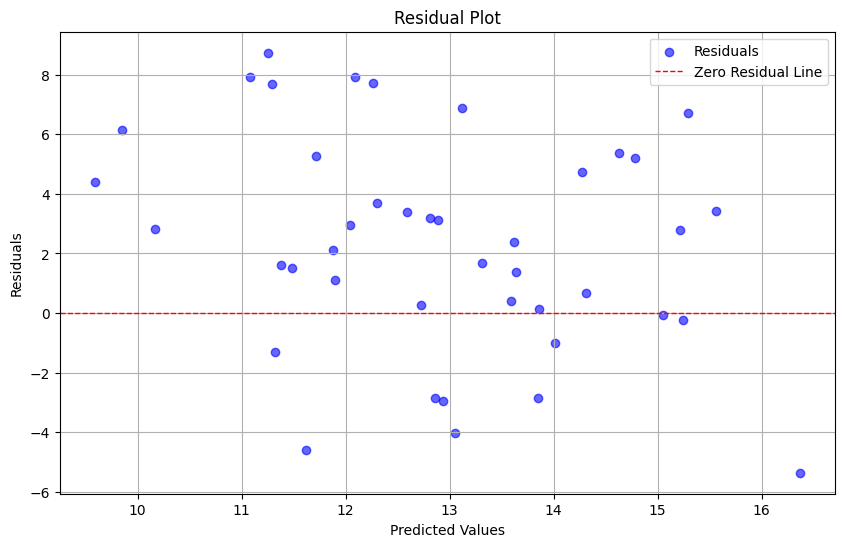

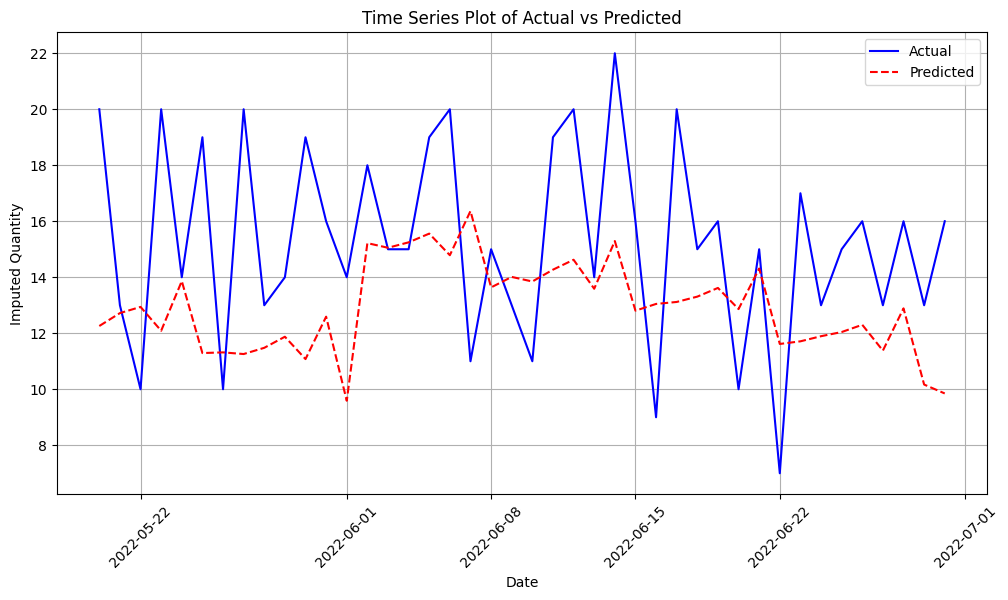

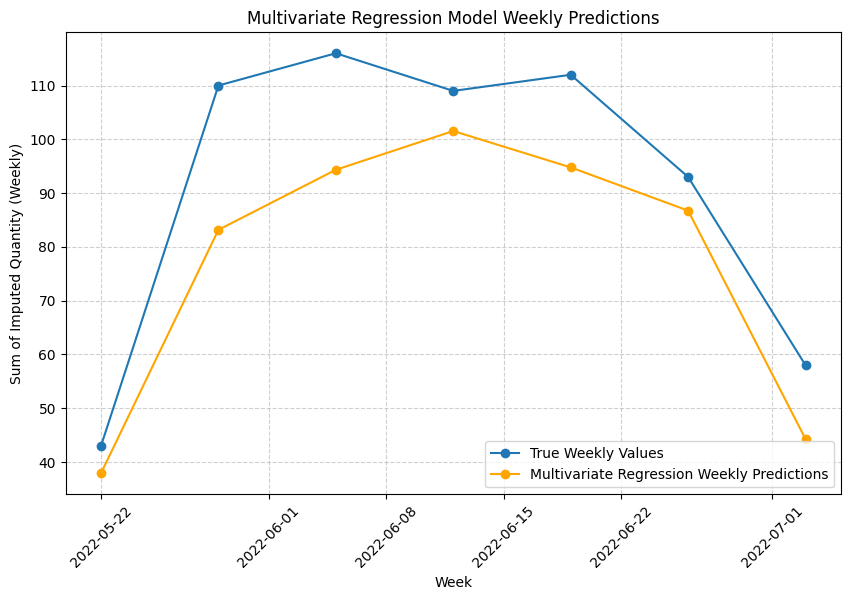

In [501]:
# Step 1: Prepare the Data (Assuming 'final' is the dataframe you have)
# Ensure the dataframe is sorted by 'Day Index'
final = final.sort_values('Day Index')

# Ensure 'Day Index' is in datetime format and set it as the index
final['Day Index'] = pd.to_datetime(final['Day Index'])
final.set_index('Day Index', inplace=True)  # Set 'Day Index' as the index

# Step 2: Create lagged features (e.g., 3 lags for both target and predictors)
def create_lagged_features(df, target_col, lag_cols, max_lags=3):
    for col in lag_cols:
        for lag in range(1, max_lags + 1):
            df[f'{col}_lag_{lag}'] = df[col].shift(lag)

    # For the target variable, we create lagged features
    for lag in range(1, max_lags + 1):
        df[f'{target_col}_lag_{lag}'] = df[target_col].shift(lag)

    # Drop the rows with missing values due to shifting
    df = df.dropna()
    return df

# Specify the target column and the predictors
target_col = 'imputed_quantity'  # Target variable (use 'Quantity' if you prefer)
predictors = ['Clicks', 'Impressions', 'MonthNum', 'weekOfMonth', 'daysOfWeekNum', 
              'Weekday_Monday', 'Weekday_Tuesday', 'Weekday_Wednesday', 'Weekday_Thursday', 
              'Weekday_Friday', 'Weekday_Saturday', 'Weekday_Sunday', 'Weekday_January', 
              'Weekday_February', 'Weekday_March', 'Weekday_April', 'Weekday_May', 
              'Weekday_June', 'Weekday_July', 'Weekday_August', 'Weekday_September', 
              'Weekday_October', 'Weekday_November', 'Weekday_December']

# Step 3: Create lagged features
final = create_lagged_features(final, target_col, predictors, max_lags=3)

# Step 4: Prepare the data for regression
# We'll only use the lag_1 values for both predictors and target variable
X = final[[f'{col}_lag_1' for col in predictors]]
X = sm.add_constant(X)  # Add a constant term (intercept)

# Use the 'lag_1' for the target variable
y = final[f'{target_col}_lag_1']  # Only take the lag_1 target

# Ensure no NaN or infinite values in X and y
X = X.replace([np.inf, -np.inf], np.nan).dropna()  # Remove inf/nan from X
y = y.loc[X.index]  # Align y with the cleaned X

# Step 5: Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Step 6: Fit the regression model
model = sm.OLS(y_train, X_train).fit()

# Step 7: Get the model summary
print(model.summary())

# Step 8: Make predictions
y_pred = model.predict(X_test)

# Optional: Evaluate model performance (e.g., RMSE)
rmse = math.sqrt(mean_squared_error(y_test, y_pred))
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

# Calculate Mean Absolute Percentage Error (MAPE)
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

# Print the error metrics
print(f'Root Mean Squared Error (RMSE): {rmse}')
print(f'Mean Squared Error (MSE): {mse}')
print(f'Mean Absolute Error (MAE): {mae}')
print(f'Mean Absolute Percentage Error (MAPE): {mape}%')

# ------------- Plotting -------------------

# 1. Plot Actual vs Predicted Values
plt.figure(figsize=(10, 6))
plt.plot(y_test.values, label='Actual', color='blue', marker='o')
plt.plot(y_pred.values, label='Predicted', color='red', linestyle='--', marker='x')
plt.title('Actual vs Predicted - Dynamic Multivariate Regression')
plt.xlabel('Time')
plt.ylabel('Imputed Quantity')
plt.legend()
plt.grid(True)
plt.show()

# 2. Simplified Residual Plot
residuals = y_test - y_pred

plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals, color='blue', alpha=0.6, label='Residuals')  # Label for residuals
plt.axhline(y=0, color='red', linestyle='--', linewidth=1, label='Zero Residual Line')  # Label for the reference line
plt.title('Residual Plot')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.legend()  # Display the legend
plt.grid(True)
plt.show()

# 3. Time Series Plot of Actual vs Predicted
plt.figure(figsize=(12, 6))
plt.plot(final.index[-len(y_test):], y_test, label='Actual', color='blue')
plt.plot(final.index[-len(y_test):], y_pred, label='Predicted', color='red', linestyle='--')
plt.title('Time Series Plot of Actual vs Predicted')
plt.xlabel('Date')
plt.ylabel('Imputed Quantity')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.show()

# ------------- Weekly Comparison Plot ---------------
def plot_weekly_comparisons(true_values, predicted_values, date_index, model_name):
    # Create the weekly resampling of the data using 'Day Index'
    true_weekly = true_values.resample('W').sum()
    predicted_weekly = pd.Series(predicted_values, index=date_index).resample('W').sum()

    # Plotting
    plt.figure(figsize=(10, 6))
    plt.plot(true_weekly.index, true_weekly, label='True Weekly Values', marker='o')
    plt.plot(predicted_weekly.index, predicted_weekly, label=f'{model_name} Weekly Predictions', marker='o', color='orange')

    # Labeling the axes
    plt.xlabel("Week")
    plt.ylabel("Sum of Imputed Quantity (Weekly)")
    plt.title(f'{model_name} Model Weekly Predictions')
    plt.xticks(rotation=45)  # Rotate x-axis labels if needed for readability

    # Adding the legend
    plt.legend()

    # Display the plot
    plt.grid(visible=True, linestyle='--', alpha=0.6)
    plt.show()

# Call the weekly comparison plot function
plot_weekly_comparisons(y_test, y_pred, final.index[-len(y_test):], model_name='Multivariate Regression')


**Conclusion**
- *RMSC value is 4.2*
- *SARIMAX Model predictions captured seasonality and generalized well to data while modeling better than multivariate regression (dynamic).*
- *Finnally we are choosimg SARIMAX Model for forecasting.*